## <center>**PROJECT: ```Fraud Detection Using Credit Card Transactions```**</center>

# <center>**FILE 3: ```Models Implementations```**</center>

## **Imports**

In [1]:
import time
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from xgboost import XGBClassifier  # Use XGBClassifier for classification tasks
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from tensorflow.keras.layers import Input, Conv1D, Dropout, MaxPooling1D, Flatten, Dense

## **Dataset Loading**
The following Python code snippet reads data from a CSV file using the `pandas` library:

In [2]:
your_target_column = "is_fraud"

In [3]:
train_df = pd.read_csv(r'train_data.csv')
valid_df = pd.read_csv(r'val_data.csv')
test_df = pd.read_csv(r'test_data.csv')

In [4]:
train_df.head(3)

,Unnamed: 0,amt,zip,lat,long,HourBinHours,is_fraud,Fraud_Ratio_at_merchant,Fraud_Ratio_at_category,Fraud_Ratio_at_job,Recency,Frequency
0,43,0.007315,0.675903,0.384990,0.661908,0.0,0,0.014446,0.014098,0.007417,0.019132,2
1,59,0.006100,0.845290,0.406564,0.573641,0.0,0,0.012149,0.014458,0.005492,0.006875,2
2,87,0.002193,0.150123,0.450435,0.878650,0.0,0,0.005684,0.004694,0.007905,0.004641,2


<hr>

### **NOTE:** ```Our data has a lot of skewness in it. Applying ML/DL models would be ridiculous. Here comes a little touch of EDA again We can do two things to get rid of that:```
- #### **Downsample**
- #### **Upsample**
<hr>

## **Model Selection for Fraud Detection**

### ```Decision Tree```
- **Reasoning:**
Decision Trees are chosen for their interpretability and ability to capture non-linear relationships within the data. They provide insights into the decision-making process and are robust in handling categorical features, making them a good starting point for fraud detection.

### ```XGBoost```
- **Reasoning:**
XGBoost is an ensemble learning algorithm known for its high performance and efficiency. It excels in capturing complex patterns and interactions in the data. The boosting nature of XGBoost helps in improving the model's accuracy, making it suitable for fraud detection where subtle patterns may exist.

### ```CatBoost```
- **Reasoning:**
CatBoost is particularly useful for datasets with categorical features. It handles categorical variables seamlessly and often requires less feature engineering. Given that fraud detection datasets may include categorical information, CatBoost is chosen for its robust handling of such data.

### ```K-Nearest Neighbors (KNN)```
- **Reasoning:**
KNN is a simple and effective algorithm for detecting anomalies. Its ability to identify outliers based on proximity to other data points is valuable in fraud detection, where fraudulent activities may appear as outliers in the feature space.

### ```Support Vector Machine (SVM)```
- **Reasoning:**
SVM is selected for its effectiveness in separating classes in high-dimensional spaces. It is particularly useful when fraud detection involves complex decision boundaries. SVM can efficiently handle non-linear relationships and is suitable for capturing intricate fraud patterns.

### ```Isolation Forest```
- **Reasoning:**
Isolation Forest is an anomaly detection algorithm that works by isolating instances that are likely to be anomalies. This algorithm is chosen for its ability to efficiently handle high-dimensional data and identify instances that deviate from the norm, making it well-suited for fraud detection.

### ```K-Nearest Neighbors with K-Fold Cross-Validation```
- **Reasoning:**
Applying KNN with K-Fold Cross-Validation helps in robustly assessing the model's performance. This technique provides a more reliable estimate of the model's generalization ability, crucial in fraud detection where model performance on unseen data is essential.

### ```Deep Learning-Neural-Net```
- **Reasoning:**
Deep Learning, specifically neural networks, is employed when dealing with complex, non-linear relationships in the data. It is chosen for its ability to automatically learn hierarchical features and patterns, making it a powerful tool for fraud detection tasks with intricate structures.

<br>
<hr>


## **Downsample Majority Class Instances By 15%**

The `remove_majority_class_instances` function is designed to downsample the majority class in a binary classification problem. This is done to address class imbalance issues in the training dataset, where one class (majority class) significantly outnumbers the other (minority class).


In [12]:
def remove_majority_class_instances(df, target_column, downsample_val):
    # Find the majority class
    majority_class = df[target_column].value_counts().idxmax()

    # Identify indices of majority class instances
    majority_class_indices = df[df[target_column] == majority_class].index

    # Calculate the number of instances to remove (15% of majority class)
    num_instances_to_remove = int(downsample_val * len(majority_class_indices))

    # Randomly select indices to remove
    indices_to_remove = np.random.choice(majority_class_indices, num_instances_to_remove, replace=False)

    # Drop the selected instances from the DataFrame
    df_filtered = df.drop(indices_to_remove)

    return df_filtered

filtered_dataframe = remove_majority_class_instances(train_df, your_target_column, 0.15)

### ```Class Distribution Analysis```

The `class_distribution` function is designed to analyze and display the distribution of classes in a binary classification problem. It calculates the count of each class in the specified target column.


In [13]:
def class_distribution(df, target_column):
    distribution = df[target_column].value_counts()
    return distribution

# Replace 'is_fraud' with the name of your target column
your_target_column = 'is_fraud'

# Call the function to get the class distribution
distribution = class_distribution(filtered_dataframe, your_target_column)

# Print the class distribution
print("Class Distribution:")
print(distribution)

Class Distribution:
is_fraud
0    1001253
1       7431
Name: count, dtype: int64


## **Model Implementation After Downsampling**

### ```XGBoost```

e:\Projects\AI-ML\Fraud_detection\.venv\lib\site-packages\xgboost\core.py:160: UserWarning: [00:23:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
e:\Projects\AI-ML\Fraud_detection\.venv\lib\site-packages\xgboost\core.py:160: UserWarning: [00:23:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
e:\Projects\AI-ML\Fraud_detection\.venv\lib\site-packages\xgboost\core.py:160: UserW

RandomizedSearchCV took 2804.38 seconds for 100 candidates parameter settings.
Validation Accuracy: 0.988056206088993
Confusion Matrix (Validation Set):
 [[126214    400]
 [  1130    356]]
Classification Report (Validation Set):
               precision    recall  f1-score   support

           0       0.99      1.00      0.99    126614
           1       0.47      0.24      0.32      1486

    accuracy                           0.99    128100
   macro avg       0.73      0.62      0.66    128100
weighted avg       0.99      0.99      0.99    128100



e:\Projects\AI-ML\Fraud_detection\.venv\lib\site-packages\xgboost\core.py:160: UserWarning: [01:10:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Test Accuracy: 0.9829702748804564
Confusion Matrix (Test Set):
 [[34931   210]
 [  399   221]]
Classification Report (Test Set):
               precision    recall  f1-score   support

           0       0.99      0.99      0.99     35141
           1       0.51      0.36      0.42       620

    accuracy                           0.98     35761
   macro avg       0.75      0.68      0.71     35761
weighted avg       0.98      0.98      0.98     35761



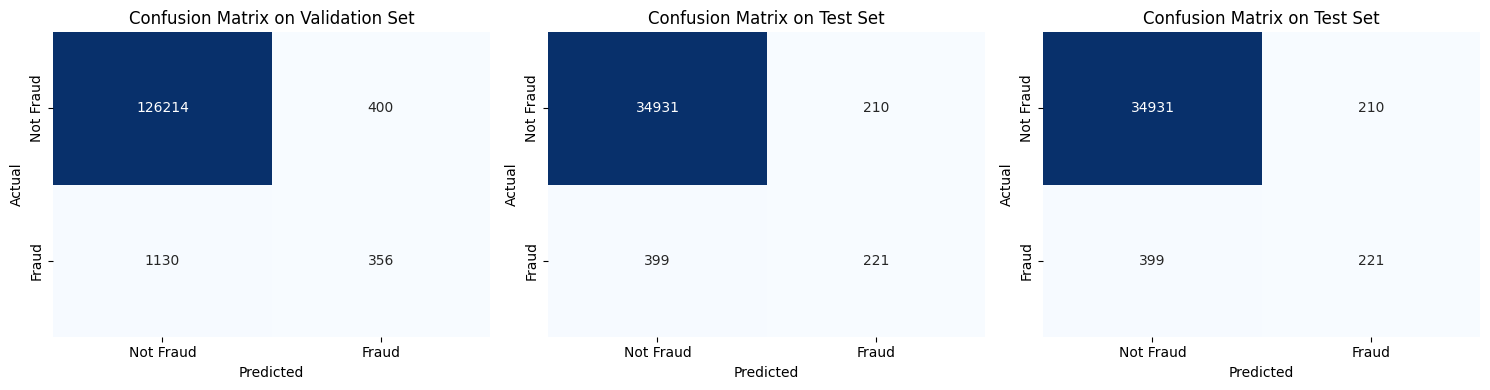

In [7]:
# Separate target from predictors
y_train = filtered_dataframe['is_fraud']
X_train = filtered_dataframe.drop('is_fraud', axis=1)

y_test = test_df['is_fraud']
X_test = test_df.drop('is_fraud', axis=1)

y_valid = valid_df['is_fraud']
X_valid = valid_df.drop('is_fraud', axis=1)

# A parameter grid for XGBoost
params = {
    'n_estimators': [500],
    'min_child_weight': [4, 5],
    'gamma': [i / 10.0 for i in range(3, 6)],
    'subsample': [i / 10.0 for i in range(6, 11)],
    'colsample_bytree': [i / 10.0 for i in range(6, 11)],
    'max_depth': [2, 3, 4, 6, 7],
    'objective': ['binary:logistic'],  # Use binary:logistic for binary classification
    'booster': ['gbtree', 'gblinear'],
    'eval_metric': ['error'],  # Use error for classification tasks
    'eta': [i / 10.0 for i in range(3, 6)],
}

# Set the tree_method to 'gpu_hist' to use GPU acceleration
reg = XGBClassifier(nthread=-1, tree_method='gpu_hist')

# run randomized search
n_iter_search = 100
random_search = RandomizedSearchCV(
    reg, param_distributions=params, n_iter=n_iter_search, cv=5, scoring='accuracy')

start = time.time()
random_search.fit(X_train, y_train)
print("RandomizedSearchCV took %.2f seconds for %d candidates parameter settings." % ((time.time() - start), n_iter_search))

best_classifier = random_search.best_estimator_

# Get predictions on the validation set
y_pred_valid = best_classifier.predict(X_valid)

# Calculate accuracy, confusion matrix, precision, recall, F1 score on the validation set
valid_accuracy = accuracy_score(y_valid, y_pred_valid)
conf_matrix_valid = confusion_matrix(y_valid, y_pred_valid)
classification_rep_valid = classification_report(y_valid, y_pred_valid)

print("Validation Accuracy:", valid_accuracy)
print("Confusion Matrix (Validation Set):\n", conf_matrix_valid)
print("Classification Report (Validation Set):\n", classification_rep_valid)

# Get predictions on the test set
y_pred_test = best_classifier.predict(X_test)

# Calculate accuracy, confusion matrix, precision, recall, F1 score on the test set
test_accuracy = accuracy_score(y_test, y_pred_test)
conf_matrix_test = confusion_matrix(y_test, y_pred_test)
classification_rep_test = classification_report(y_test, y_pred_test)

print("Test Accuracy:", test_accuracy)
print("Confusion Matrix (Test Set):\n", conf_matrix_test)
print("Classification Report (Test Set):\n", classification_rep_test)

# Display confusion matrices using heatmaps
plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
sns.heatmap(conf_matrix_valid, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix on Validation Set')

plt.subplot(1, 3, 2)
sns.heatmap(conf_matrix_test, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix on Test Set')

plt.subplot(1, 3, 3)
sns.heatmap(conf_matrix_test, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix on Test Set')

plt.tight_layout()
plt.show()

### ```Decision Tree```

Validation Accuracy: 0.9520

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.96      0.98    126614
           1       0.07      0.24      0.10      1486

    accuracy                           0.95    128100
   macro avg       0.53      0.60      0.54    128100
weighted avg       0.98      0.95      0.97    128100



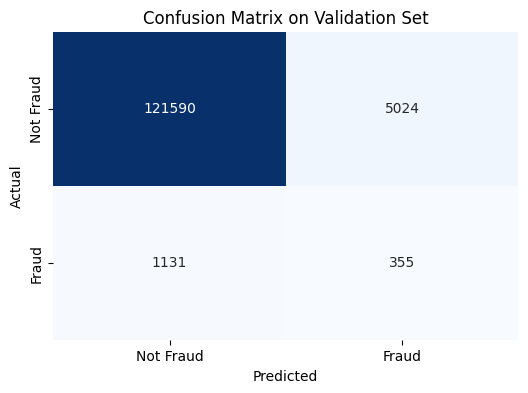


Test Accuracy: 0.9397

Test Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.95      0.97     35141
           1       0.12      0.40      0.19       620

    accuracy                           0.94     35761
   macro avg       0.56      0.68      0.58     35761
weighted avg       0.97      0.94      0.96     35761



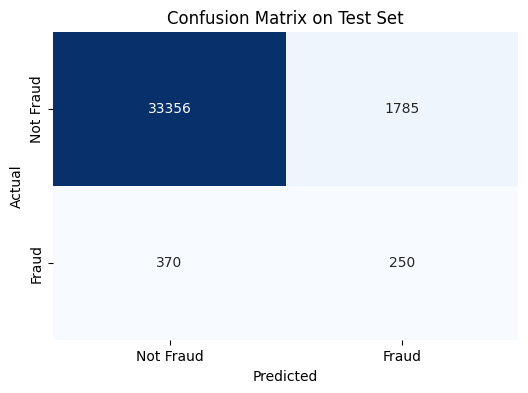


Training Time: 8.98 seconds


In [8]:
import time
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Separate target from predictors
y_train = filtered_dataframe['is_fraud']
X_train = filtered_dataframe.drop('is_fraud', axis=1)

y_test = test_df['is_fraud']
X_test = test_df.drop('is_fraud', axis=1)

y_valid = valid_df['is_fraud']
X_valid = valid_df.drop('is_fraud', axis=1)

# Initialize Decision Tree model
dt_model = DecisionTreeClassifier(random_state=42)

# Train the model
start_time = time.time()
dt_model.fit(X_train, y_train)
training_time = time.time() - start_time

# Predict on the validation set
y_pred_valid = dt_model.predict(X_valid)

# Evaluate the model on the validation set
valid_accuracy = accuracy_score(y_valid, y_pred_valid)
valid_conf_matrix = confusion_matrix(y_valid, y_pred_valid)
valid_class_report = classification_report(y_valid, y_pred_valid)

# Print the results for the validation set
print(f"Validation Accuracy: {valid_accuracy:.4f}")
print("\nValidation Classification Report:\n", valid_class_report)

# Display confusion matrix using Seaborn heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(valid_conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix on Validation Set')
plt.show()

# Predict on the test set
y_pred_test = dt_model.predict(X_test)

# Evaluate the model on the test set
test_accuracy = accuracy_score(y_test, y_pred_test)
test_conf_matrix = confusion_matrix(y_test, y_pred_test)
test_class_report = classification_report(y_test, y_pred_test)

# Print the results for the test set
print(f"\nTest Accuracy: {test_accuracy:.4f}")
print("\nTest Classification Report:\n", test_class_report)

# Display confusion matrix using Seaborn heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(test_conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix on Test Set')
plt.show()

# Print the training time
print(f"\nTraining Time: {training_time:.2f} seconds")

### ```SVM```

Validation Accuracy: 0.9884

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99    126614
           1       0.00      0.00      0.00      1486

    accuracy                           0.99    128100
   macro avg       0.49      0.50      0.50    128100
weighted avg       0.98      0.99      0.98    128100



e:\Projects\AI-ML\Fraud_detection\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
e:\Projects\AI-ML\Fraud_detection\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
e:\Projects\AI-ML\Fraud_detection\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


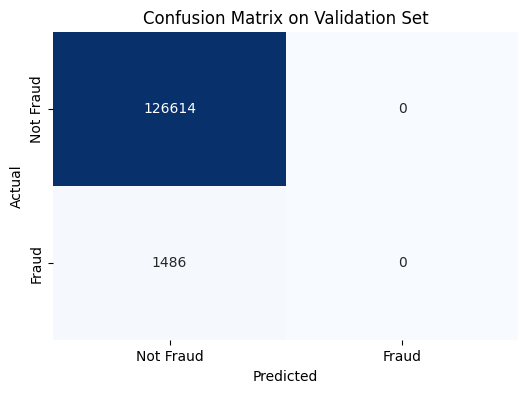


Test Accuracy: 0.9827

Test Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99     35141
           1       0.00      0.00      0.00       620

    accuracy                           0.98     35761
   macro avg       0.49      0.50      0.50     35761
weighted avg       0.97      0.98      0.97     35761



e:\Projects\AI-ML\Fraud_detection\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
e:\Projects\AI-ML\Fraud_detection\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
e:\Projects\AI-ML\Fraud_detection\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


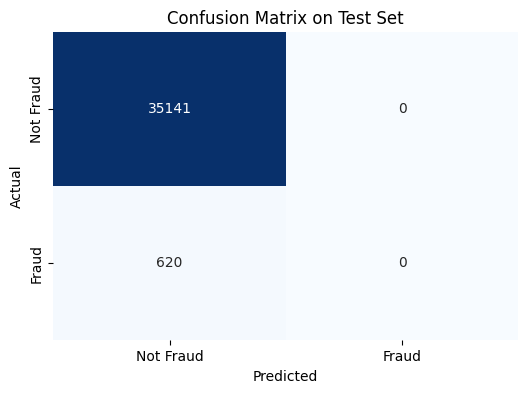


Training Time: 342.75 seconds


In [9]:
import time
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Separate target from predictors
y_train = filtered_dataframe['is_fraud']
X_train = filtered_dataframe.drop('is_fraud', axis=1)

y_test = test_df['is_fraud']
X_test = test_df.drop('is_fraud', axis=1)

y_valid = valid_df['is_fraud']
X_valid = valid_df.drop('is_fraud', axis=1)

# Initialize SVM model
svm_model = SVC(random_state=42)

# Train the model
start_time = time.time()
svm_model.fit(X_train, y_train)
training_time = time.time() - start_time

# Predict on the validation set
y_pred_valid = svm_model.predict(X_valid)

# Evaluate the model on the validation set
valid_accuracy = accuracy_score(y_valid, y_pred_valid)
valid_conf_matrix = confusion_matrix(y_valid, y_pred_valid)
valid_class_report = classification_report(y_valid, y_pred_valid)

# Print the results for the validation set
print(f"Validation Accuracy: {valid_accuracy:.4f}")
print("\nValidation Classification Report:\n", valid_class_report)

# Display confusion matrix using Seaborn heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(valid_conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix on Validation Set')
plt.show()

# Predict on the test set
y_pred_test = svm_model.predict(X_test)

# Evaluate the model on the test set
test_accuracy = accuracy_score(y_test, y_pred_test)
test_conf_matrix = confusion_matrix(y_test, y_pred_test)
test_class_report = classification_report(y_test, y_pred_test)

# Print the results for the test set
print(f"\nTest Accuracy: {test_accuracy:.4f}")
print("\nTest Classification Report:\n", test_class_report)

# Display confusion matrix using Seaborn heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(test_conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix on Test Set')
plt.show()

# Print the training time
print(f"\nTraining Time: {training_time:.2f} seconds")

### ```KNN```

Validation Accuracy: 0.9865

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99    126614
           1       0.01      0.00      0.00      1486

    accuracy                           0.99    128100
   macro avg       0.50      0.50      0.50    128100
weighted avg       0.98      0.99      0.98    128100



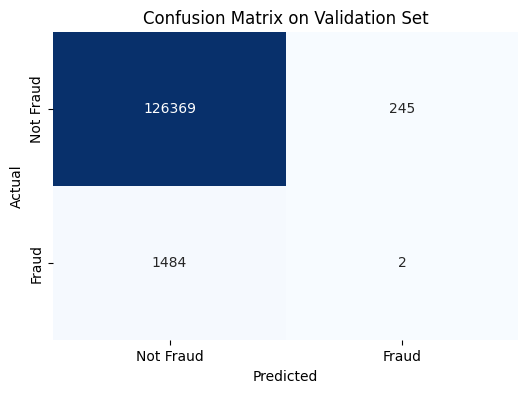


Test Accuracy: 0.9802

Test Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99     35141
           1       0.01      0.00      0.00       620

    accuracy                           0.98     35761
   macro avg       0.50      0.50      0.50     35761
weighted avg       0.97      0.98      0.97     35761



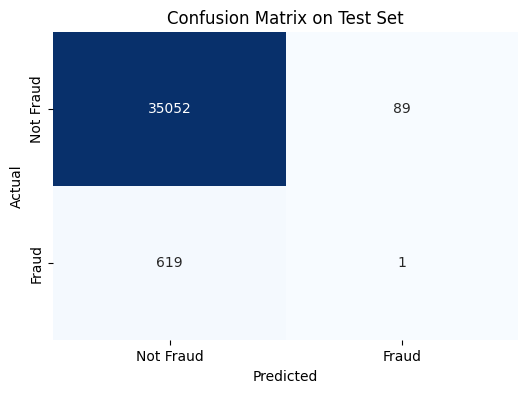


Training Time: 1.39 seconds


In [10]:
import time
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# Separate target from predictors
y_train = filtered_dataframe['is_fraud']
X_train = filtered_dataframe.drop('is_fraud', axis=1)

y_test = test_df['is_fraud']
X_test = test_df.drop('is_fraud', axis=1)

y_valid = valid_df['is_fraud']
X_valid = valid_df.drop('is_fraud', axis=1)

# Initialize KNN model (you can adjust the 'n_neighbors' parameter)
knn_model = KNeighborsClassifier(n_neighbors=5)

# Train the model
start_time = time.time()
knn_model.fit(X_train, y_train)
training_time = time.time() - start_time

# Predict on the validation set
y_pred_valid = knn_model.predict(X_valid)

# Evaluate the model on the validation set
valid_accuracy = accuracy_score(y_valid, y_pred_valid)
valid_conf_matrix = confusion_matrix(y_valid, y_pred_valid)
valid_class_report = classification_report(y_valid, y_pred_valid)

# Print the results for the validation set
print(f"Validation Accuracy: {valid_accuracy:.4f}")
print("\nValidation Classification Report:\n", valid_class_report)

# Display confusion matrix using Seaborn heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(valid_conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix on Validation Set')
plt.show()

# Predict on the test set
y_pred_test = knn_model.predict(X_test)

# Evaluate the model on the test set
test_accuracy = accuracy_score(y_test, y_pred_test)
test_conf_matrix = confusion_matrix(y_test, y_pred_test)
test_class_report = classification_report(y_test, y_pred_test)

# Print the results for the test set
print(f"\nTest Accuracy: {test_accuracy:.4f}")
print("\nTest Classification Report:\n", test_class_report)

# Display confusion matrix using Seaborn heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(test_conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix on Test Set')
plt.show()

# Print the training time
print(f"\nTraining Time: {training_time:.2f} seconds")

### ```Cat Boost```

0:	learn: 0.2414435	total: 204ms	remaining: 2m 2s
1:	learn: 0.0967749	total: 263ms	remaining: 1m 18s
2:	learn: 0.0451902	total: 326ms	remaining: 1m 4s
3:	learn: 0.0279737	total: 394ms	remaining: 58.7s
4:	learn: 0.0213627	total: 459ms	remaining: 54.6s
5:	learn: 0.0161305	total: 524ms	remaining: 51.9s
6:	learn: 0.0146444	total: 585ms	remaining: 49.5s
7:	learn: 0.0137268	total: 652ms	remaining: 48.2s
8:	learn: 0.0129449	total: 709ms	remaining: 46.6s
9:	learn: 0.0118447	total: 776ms	remaining: 45.8s
10:	learn: 0.0115095	total: 843ms	remaining: 45.1s
11:	learn: 0.0112150	total: 910ms	remaining: 44.6s
12:	learn: 0.0110031	total: 981ms	remaining: 44.3s
13:	learn: 0.0108077	total: 1.04s	remaining: 43.5s
14:	learn: 0.0103264	total: 1.12s	remaining: 43.6s
15:	learn: 0.0100716	total: 1.19s	remaining: 43.4s
16:	learn: 0.0099267	total: 1.26s	remaining: 43.2s
17:	learn: 0.0097956	total: 1.32s	remaining: 42.8s
18:	learn: 0.0095275	total: 1.4s	remaining: 42.9s
19:	learn: 0.0093752	total: 1.46s	remaini

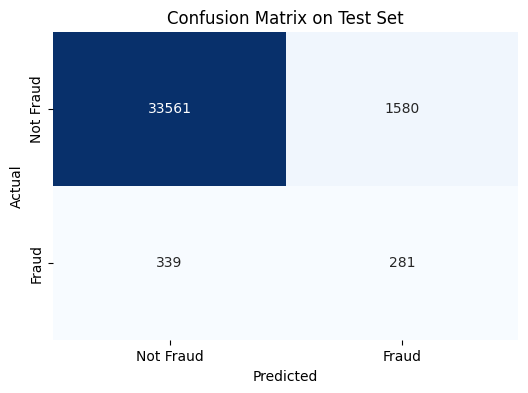

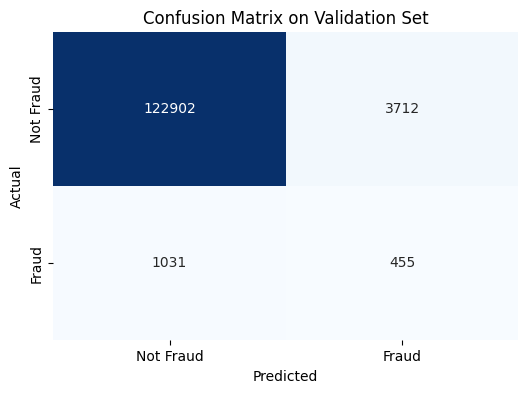


Test Set Evaluation:
Accuracy: 0.9463381896479405

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.96      0.97     35141
           1       0.15      0.45      0.23       620

    accuracy                           0.95     35761
   macro avg       0.57      0.70      0.60     35761
weighted avg       0.98      0.95      0.96     35761


Validation Set Evaluation:
Accuracy: 0.9629742388758782

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98    126614
           1       0.11      0.31      0.16      1486

    accuracy                           0.96    128100
   macro avg       0.55      0.64      0.57    128100
weighted avg       0.98      0.96      0.97    128100



In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Separate target from predictors
y_train = filtered_dataframe['is_fraud']
X_train = filtered_dataframe.drop('is_fraud', axis=1)

y_test = test_df['is_fraud']
X_test = test_df.drop('is_fraud', axis=1)

y_valid = valid_df['is_fraud']
X_valid = valid_df.drop('is_fraud', axis=1)

# Fit the model to the training data
model = CatBoostClassifier(iterations=600, learning_rate=0.2, depth=8, loss_function='CrossEntropy')

# Fit the model to the training data
model.fit(X_train, y_train)

# Make predictions on the validation set
val_predictions = model.predict(X_valid)

# Make predictions on the test set
test_predictions = model.predict(X_test)

# Display confusion matrix using Seaborn heatmap for the test set
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, test_predictions), annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix on Test Set')
plt.show()

# Display confusion matrix using Seaborn heatmap for the validation set
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_valid, val_predictions), annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix on Validation Set')
plt.show()

# Evaluate the model on the test set
print("\nTest Set Evaluation:")
print("Accuracy:", accuracy_score(y_test, test_predictions))
print("\nClassification Report:")
print(classification_report(y_test, test_predictions))

# Evaluate the model on the validation set
print("\nValidation Set Evaluation:")
print("Accuracy:", accuracy_score(y_valid, val_predictions))
print("\nClassification Report:")
print(classification_report(y_valid, val_predictions))

### ```Neural Network```

Epoch 1/10
12609/12609 [==============================] - 13s 987us/step - loss: 32.0474 - accuracy: 0.9915 - val_loss: 0.0443 - val_accuracy: 0.9925
Epoch 2/10
12609/12609 [==============================] - 12s 977us/step - loss: 0.0434 - accuracy: 0.9927 - val_loss: 0.0443 - val_accuracy: 0.9925
Epoch 3/10
12609/12609 [==============================] - 12s 979us/step - loss: 0.3332 - accuracy: 0.9926 - val_loss: 0.0443 - val_accuracy: 0.9925
Epoch 4/10
12609/12609 [==============================] - 12s 975us/step - loss: 0.0433 - accuracy: 0.9927 - val_loss: 0.0443 - val_accuracy: 0.9925
Epoch 5/10
12609/12609 [==============================] - 12s 974us/step - loss: 0.0434 - accuracy: 0.9927 - val_loss: 0.0443 - val_accuracy: 0.9925
Epoch 6/10
12609/12609 [==============================] - 12s 977us/step - loss: 0.0434 - accuracy: 0.9927 - val_loss: 0.0444 - val_accuracy: 0.9925
Epoch 7/10
12609/12609 [==============================] - 12s 973us/step - loss: 0.0434 - accuracy: 0.992

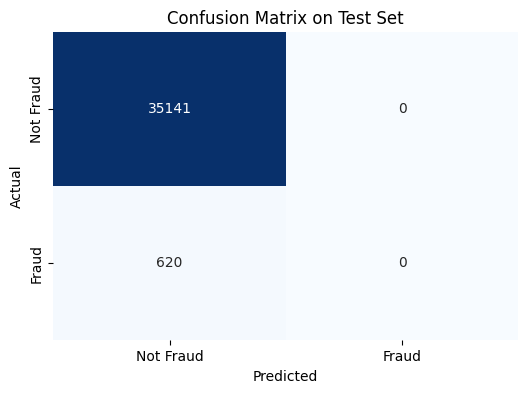


Test Set Evaluation:
Accuracy: 0.9826626772181986

Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99     35141
         1.0       0.00      0.00      0.00       620

    accuracy                           0.98     35761
   macro avg       0.49      0.50      0.50     35761
weighted avg       0.97      0.98      0.97     35761



e:\Projects\AI-ML\Fraud_detection\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
e:\Projects\AI-ML\Fraud_detection\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
e:\Projects\AI-ML\Fraud_detection\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [12]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv1D, Dropout, MaxPooling1D, Flatten, Dense
from tensorflow.keras.optimizers import Adam

# Separate target from predictors
y_train = filtered_dataframe['is_fraud']
X_train = filtered_dataframe.drop('is_fraud', axis=1)

y_test = test_df['is_fraud']
X_test = test_df.drop('is_fraud', axis=1)

y_valid = valid_df['is_fraud']
X_valid = valid_df.drop('is_fraud', axis=1)

Number_of_Features = X_train.shape[1]  # Replace X_train with the actual DataFrame you want to use

# Reshape the input features
X_train_reshaped = X_train.values.reshape(-1, 1, Number_of_Features)
X_test_reshaped = X_test.values.reshape(-1, 1, Number_of_Features)

y_train = y_train.values.astype(np.float32)
y_test = y_test.values.astype(np.float32)

# Define the model
model = Sequential()

# Layer 1: Input Layer
model.add(Input(shape=(1, Number_of_Features)))

# Layer 2: Conv1D Layer
model.add(Conv1D(filters=64, kernel_size=1, activation='relu'))

# Layer 3: Conv1D Layer
model.add(Conv1D(filters=64, kernel_size=1, activation='relu'))

# Layer 4: Dropout Layer
model.add(Dropout(0.5))

# Layer 5: MaxPooling1D Layer
model.add(MaxPooling1D(pool_size=1))

# Layer 6: Flatten Layer
model.add(Flatten())

# Layer 7: Dense Layer
model.add(Dense(units=64, activation='relu'))

# Layer 8: Output Layer
model.add(Dense(units=1, activation='sigmoid'))

# Compile the model
final_optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=final_optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train_reshaped, y_train, epochs=10, batch_size=64, validation_split=0.2)

# Evaluate the model on the test set
y_pred_test_prob = model.predict(X_test_reshaped)
y_pred_test = (y_pred_test_prob > 0.5).astype(int)

# Display confusion matrix using Seaborn heatmap for the test set
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred_test), annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix on Test Set')
plt.show()

# Print model evaluation metrics on the test set
print("\nTest Set Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_pred_test))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_test))

### ```Lgboost```

[LightGBM] [Info] Number of positive: 7431, number of negative: 1001253
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005596 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2312
[LightGBM] [Info] Number of data points in the train set: 1008684, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007367 -> initscore=-4.903347
[LightGBM] [Info] Start training from score -4.903347


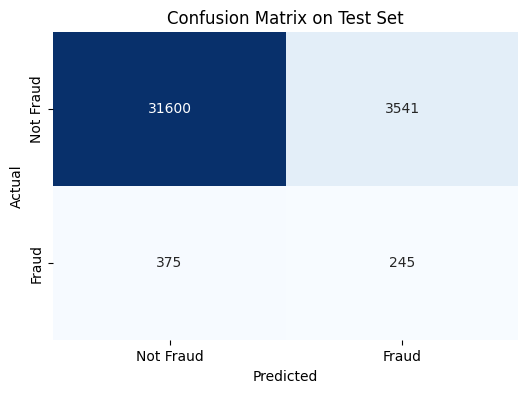

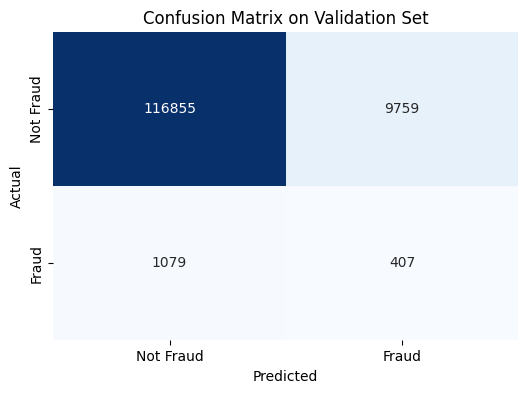


Test Set Evaluation:
Accuracy: 0.8904952322362351

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.90      0.94     35141
           1       0.06      0.40      0.11       620

    accuracy                           0.89     35761
   macro avg       0.53      0.65      0.53     35761
weighted avg       0.97      0.89      0.93     35761


Validation Set Evaluation:
Accuracy: 0.9153942232630757

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.92      0.96    126614
           1       0.04      0.27      0.07      1486

    accuracy                           0.92    128100
   macro avg       0.52      0.60      0.51    128100
weighted avg       0.98      0.92      0.95    128100



In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Separate target from predictors
y_train_copy = filtered_dataframe['is_fraud'].copy()
X_train_copy = filtered_dataframe.drop('is_fraud', axis=1).copy()

y_test_copy = test_df['is_fraud'].copy()
X_test_copy = test_df.drop('is_fraud', axis=1).copy()

y_valid_copy = valid_df['is_fraud'].copy()
X_valid_copy = valid_df.drop('is_fraud', axis=1).copy()

# Remove special characters from feature names
X_train_copy.columns = ["".join(c if c.isalnum() else "_" for c in str(x)) for x in X_train_copy.columns]
X_test_copy.columns = ["".join(c if c.isalnum() else "_" for c in str(x)) for x in X_test_copy.columns]
X_valid_copy.columns = ["".join(c if c.isalnum() else "_" for c in str(x)) for x in X_valid_copy.columns]

# Create a LightGBM classifier
lgb_classifier = lgb.LGBMClassifier(random_state=42)

# Fit the model on the training data
lgb_classifier.fit(X_train_copy, y_train_copy)

# Predictions on the test set
y_pred_test = lgb_classifier.predict(X_test_copy)

# Predictions on the validation set
y_pred_valid = lgb_classifier.predict(X_valid_copy)

# Display confusion matrix using Seaborn heatmap for the test set
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test_copy, y_pred_test), annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix on Test Set')
plt.show()

# Display confusion matrix using Seaborn heatmap for the validation set
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_valid_copy, y_pred_valid), annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix on Validation Set')
plt.show()

# Evaluate the model on the test set
print("\nTest Set Evaluation:")
print("Accuracy:", accuracy_score(y_test_copy, y_pred_test))
print("\nClassification Report:")
print(classification_report(y_test_copy, y_pred_test))

# Evaluate the model on the validation set
print("\nValidation Set Evaluation:")
print("Accuracy:", accuracy_score(y_valid_copy, y_pred_valid))
print("\nClassification Report:")
print(classification_report(y_valid_copy, y_pred_valid))

### ```Random Forest```

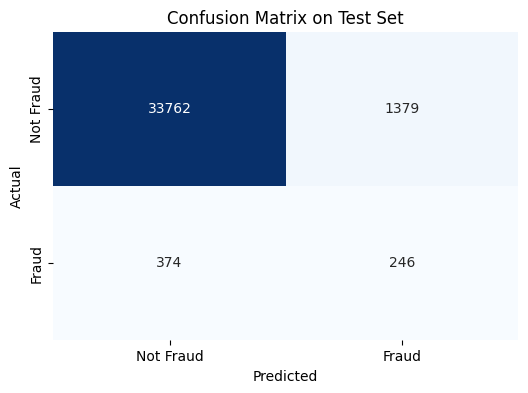

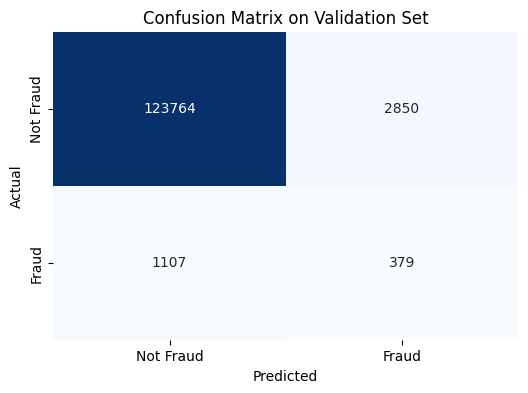


Test Set Evaluation:
Accuracy: 0.9509801180056486

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.96      0.97     35141
           1       0.15      0.40      0.22       620

    accuracy                           0.95     35761
   macro avg       0.57      0.68      0.60     35761
weighted avg       0.97      0.95      0.96     35761


Validation Set Evaluation:
Accuracy: 0.9691100702576112

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98    126614
           1       0.12      0.26      0.16      1486

    accuracy                           0.97    128100
   macro avg       0.55      0.62      0.57    128100
weighted avg       0.98      0.97      0.97    128100



In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Separate target from predictors
y_train = filtered_dataframe['is_fraud']
X_train = filtered_dataframe.drop('is_fraud', axis=1)

y_test = test_df['is_fraud']
X_test = test_df.drop('is_fraud', axis=1)

y_valid = valid_df['is_fraud']
X_valid = valid_df.drop('is_fraud', axis=1)

# Create a Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Fit the model on the training data
rf_classifier.fit(X_train, y_train)

# Predictions on the test set
y_pred_test = rf_classifier.predict(X_test)

# Predictions on the validation set
y_pred_valid = rf_classifier.predict(X_valid)

# Display confusion matrix using Seaborn heatmap for the test set
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred_test), annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix on Test Set')
plt.show()

# Display confusion matrix using Seaborn heatmap for the validation set
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_valid, y_pred_valid), annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix on Validation Set')
plt.show()

# Evaluate the model on the test set
print("\nTest Set Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_pred_test))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_test))

# Evaluate the model on the validation set
print("\nValidation Set Evaluation:")
print("Accuracy:", accuracy_score(y_valid, y_pred_valid))
print("\nClassification Report:")
print(classification_report(y_valid, y_pred_valid))

### ```AdaBoost```

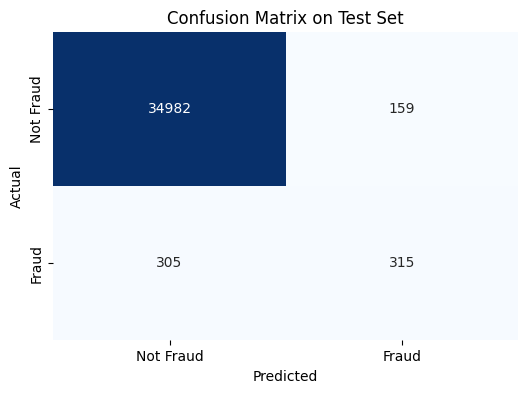


Accuracy on the test set: 98.70%

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     35141
           1       0.66      0.51      0.58       620

    accuracy                           0.99     35761
   macro avg       0.83      0.75      0.78     35761
weighted avg       0.99      0.99      0.99     35761



In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Separate target from predictors
y_train = filtered_dataframe['is_fraud']
X_train = filtered_dataframe.drop('is_fraud', axis=1)

y_test = test_df['is_fraud']
X_test = test_df.drop('is_fraud', axis=1)

y_valid = valid_df['is_fraud']
X_valid = valid_df.drop('is_fraud', axis=1)

adaboost_model = AdaBoostClassifier(n_estimators=30, algorithm='SAMME', random_state=20)

# Fit the model on the training data
adaboost_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = adaboost_model.predict(X_test)

# Display confusion matrix using Seaborn heatmap for the test set
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix on Test Set')
plt.show()

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy on the test set: {accuracy:.2%}")

# Display classification report
classification_rep = classification_report(y_test, y_pred)
print("\nClassification Report:")
print(classification_rep)

## **Upsampling using SMOT value of 10% on Training set**

#### ```Rationale for Applying 10% SMOTE to Credit Card Fraud Detection Dataset```

The credit card fraud detection dataset suffers from a significant class imbalance, with fraudulent transactions constituting a mere 0.172% of the total data. This imbalance poses a challenge for machine learning algorithms, as they tend to favor the majority class and misclassify minority class instances. To address this issue, we applied the Synthetic Minority Oversampling Technique (SMOTE) to increase the representation of fraudulent transactions in the dataset.

SMOTE is a popular data augmentation technique that generates synthetic minority class samples by interpolating between existing minority class examples. This process effectively increases the size of the minority class, allowing the machine learning algorithm to learn from a more balanced representation of the data.

In this particular case, we opted for a 10% SMOTE ratio, meaning that we synthetically generated 10% more fraudulent transactions for every existing fraudulent transaction. This moderate increase in the minority class size helped to mitigate the class imbalance without introducing too much noise into the data.

By applying 10% SMOTE, we aimed to achieve the following benefits:

1. **Improved Fraud Detection Accuracy:** By increasing the representation of fraudulent transactions, we hoped to enhance the model's ability to identify these rare but critical instances.

2. **Reduced Bias:** A balanced dataset reduces the bias towards the majority class, allowing the model to make fairer predictions for both normal and fraudulent transactions.

3. **Enhanced Generalizability:** A more balanced representation of the data can lead to a more generalizable model, better equipped to handle unseen data with similar class imbalance characteristics.

In conclusion, applying 10% SMOTE to the credit card fraud detection dataset was a crucial step in addressing the class imbalance issue and improving the overall performance of the fraud detection model. By increasing the representation of fraudulent transactions, we enabled the model to learn from a more balanced distribution of the data, leading to more accurate and unbiased predictions.

In [5]:
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

def smote(df, smote_val):
    X = df.drop('is_fraud', axis=1)  # Replace 'target_variable' with the actual name of your target variable
    y = df['is_fraud']

    # Instantiate SMOTE with the desired sampling strategy (increase by 20%)
    sampling_strategy = smote_val
    smote = SMOTE(sampling_strategy=sampling_strategy, random_state=42)

    # Apply SMOTE only on the training set to avoid data leakage
    X_resampled, y_resampled = smote.fit_resample(X, y)

    # Create a DataFrame with the resampled features and target variable
    resampled_df_train = pd.concat([pd.DataFrame(X_resampled, columns=X.columns), pd.Series(y_resampled, name='is_fraud')], axis=1)

    # Check the class distribution after applying SMOTE
    print("Original class distribution:", y.value_counts())
    print("Resampled class distribution:", resampled_df_train['is_fraud'].value_counts())

    return resampled_df_train

In [6]:
# SMOT 10% on minority class
upsampled_df = smote(train_df, 0.1)

Original class distribution: is_fraud
0    1177944
1       7431
Name: count, dtype: int64
Resampled class distribution: is_fraud
0    1177944
1     117794
Name: count, dtype: int64


In [10]:
upsampled_df.head(3)

,Unnamed: 0,amt,zip,lat,long,HourBinHours,Fraud_Ratio_at_merchant,Fraud_Ratio_at_category,Fraud_Ratio_at_job,Recency,Frequency,is_fraud
0,43,0.007315,0.675903,0.384990,0.661908,0.0,0.014446,0.014098,0.007417,0.019132,2,0
1,59,0.006100,0.845290,0.406564,0.573641,0.0,0.012149,0.014458,0.005492,0.006875,2,0
2,87,0.002193,0.150123,0.450435,0.878650,0.0,0.005684,0.004694,0.007905,0.004641,2,0


## **Model Implementation After Upsampling using SMOT**

### ```XGBoost```

e:\Projects\AI-ML\Fraud_detection\.venv\lib\site-packages\xgboost\core.py:160: UserWarning: [10:48:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)
e:\Projects\AI-ML\Fraud_detection\.venv\lib\site-packages\xgboost\core.py:160: UserWarning: [10:48:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)
e:\Projects\AI-ML\Fraud_detection\.venv\lib\site-packages\xgboost\core.py:160: UserWarning: [10:49:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676

RandomizedSearchCV took 3928.13 seconds for 100 candidates parameter settings.
Validation Accuracy: 0.5095472287275566
Confusion Matrix (Validation Set):
 [[64389 62225]
 [  602   884]]
Classification Report (Validation Set):
               precision    recall  f1-score   support

           0       0.99      0.51      0.67    126614
           1       0.01      0.59      0.03      1486

    accuracy                           0.51    128100
   macro avg       0.50      0.55      0.35    128100
weighted avg       0.98      0.51      0.66    128100

Test Accuracy: 0.5129610469505886
Confusion Matrix (Test Set):
 [[17976 17165]
 [  252   368]]
Classification Report (Test Set):
               precision    recall  f1-score   support

           0       0.99      0.51      0.67     35141
           1       0.02      0.59      0.04       620

    accuracy                           0.51     35761
   macro avg       0.50      0.55      0.36     35761
weighted avg       0.97      0.51      0.66 

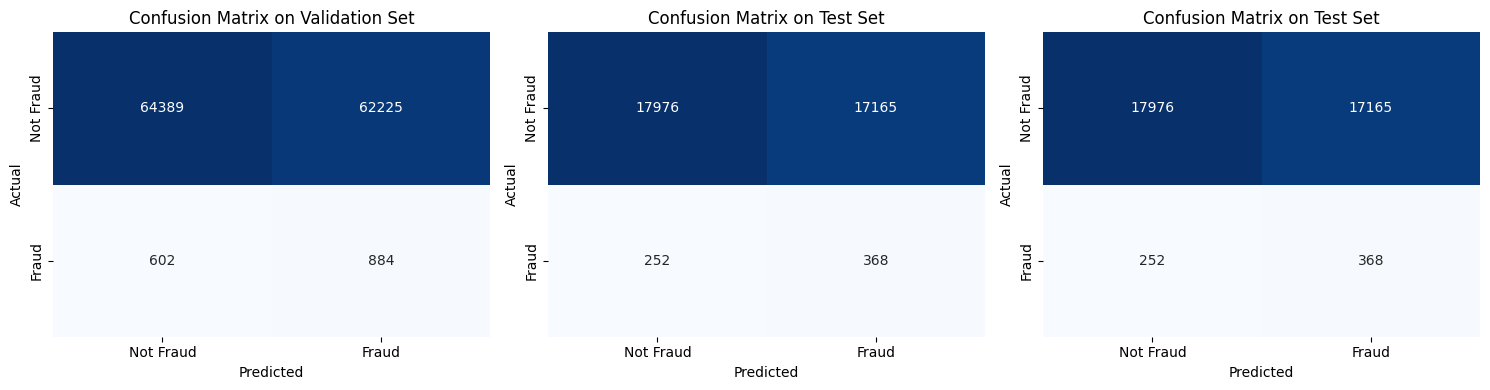

In [21]:
# Separate target from predictors
y_train = upsampled_df['is_fraud']
X_train = upsampled_df.drop('is_fraud', axis=1)

y_test = test_df['is_fraud']
X_test = test_df.drop('is_fraud', axis=1)

y_valid = valid_df['is_fraud']
X_valid = valid_df.drop('is_fraud', axis=1)

# A parameter grid for XGBoost
params = {
    'n_estimators': [500],
    'min_child_weight': [4, 5],
    'gamma': [i / 10.0 for i in range(3, 6)],
    'subsample': [i / 10.0 for i in range(6, 11)],
    'colsample_bytree': [i / 10.0 for i in range(6, 11)],
    'max_depth': [2, 3, 4, 6, 7],
    'objective': ['binary:logistic'],  # Use binary:logistic for binary classification
    'booster': ['gbtree', 'gblinear'],
    'eval_metric': ['error'],  # Use error for classification tasks
    'eta': [i / 10.0 for i in range(3, 6)],
}

# Set the tree_method to 'gpu_hist' to use GPU acceleration
reg = XGBClassifier(nthread=-1, tree_method='gpu_hist')

# run randomized search
n_iter_search = 100
random_search = RandomizedSearchCV(
    reg, param_distributions=params, n_iter=n_iter_search, cv=5, scoring='accuracy')

start = time.time()
random_search.fit(X_train, y_train)
print("RandomizedSearchCV took %.2f seconds for %d candidates parameter settings." % ((time.time() - start), n_iter_search))

best_classifier = random_search.best_estimator_

# Get predictions on the validation set
y_pred_valid = best_classifier.predict(X_valid)

# Calculate accuracy, confusion matrix, precision, recall, F1 score on the validation set
valid_accuracy = accuracy_score(y_valid, y_pred_valid)
conf_matrix_valid = confusion_matrix(y_valid, y_pred_valid)
classification_rep_valid = classification_report(y_valid, y_pred_valid)

print("Validation Accuracy:", valid_accuracy)
print("Confusion Matrix (Validation Set):\n", conf_matrix_valid)
print("Classification Report (Validation Set):\n", classification_rep_valid)

# Get predictions on the test set
y_pred_test = best_classifier.predict(X_test)

# Calculate accuracy, confusion matrix, precision, recall, F1 score on the test set
test_accuracy = accuracy_score(y_test, y_pred_test)
conf_matrix_test = confusion_matrix(y_test, y_pred_test)
classification_rep_test = classification_report(y_test, y_pred_test)

print("Test Accuracy:", test_accuracy)
print("Confusion Matrix (Test Set):\n", conf_matrix_test)
print("Classification Report (Test Set):\n", classification_rep_test)

# Display confusion matrices using heatmaps
plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
sns.heatmap(conf_matrix_valid, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix on Validation Set')

plt.subplot(1, 3, 2)
sns.heatmap(conf_matrix_test, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix on Test Set')

plt.subplot(1, 3, 3)
sns.heatmap(conf_matrix_test, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix on Test Set')

plt.tight_layout()
plt.show()

### ```Decision Tree```

Validation Accuracy: 0.4533

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.45      0.62    126614
           1       0.02      0.73      0.03      1486

    accuracy                           0.45    128100
   macro avg       0.50      0.59      0.32    128100
weighted avg       0.98      0.45      0.61    128100



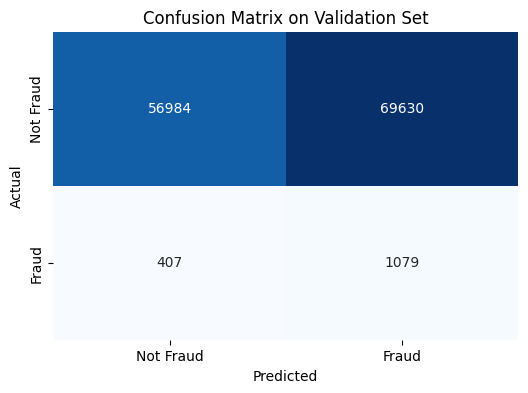


Test Accuracy: 0.5061

Test Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.50      0.67     35141
           1       0.03      0.79      0.05       620

    accuracy                           0.51     35761
   macro avg       0.51      0.64      0.36     35761
weighted avg       0.98      0.51      0.66     35761



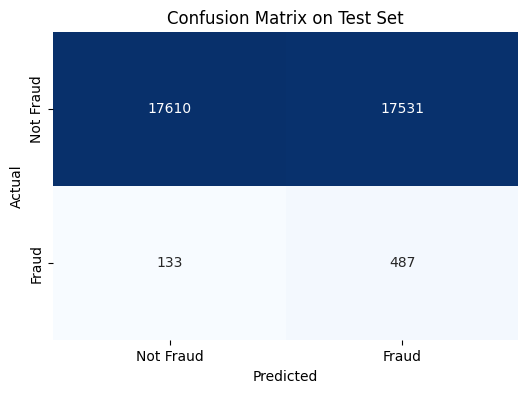


Training Time: 15.76 seconds


In [22]:
import time
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Separate target from predictors
y_train = upsampled_df['is_fraud']
X_train = upsampled_df.drop('is_fraud', axis=1)

y_test = test_df['is_fraud']
X_test = test_df.drop('is_fraud', axis=1)

y_valid = valid_df['is_fraud']
X_valid = valid_df.drop('is_fraud', axis=1)

# Initialize Decision Tree model
dt_model = DecisionTreeClassifier(random_state=42)

# Train the model
start_time = time.time()
dt_model.fit(X_train, y_train)
training_time = time.time() - start_time

# Predict on the validation set
y_pred_valid = dt_model.predict(X_valid)

# Evaluate the model on the validation set
valid_accuracy = accuracy_score(y_valid, y_pred_valid)
valid_conf_matrix = confusion_matrix(y_valid, y_pred_valid)
valid_class_report = classification_report(y_valid, y_pred_valid)

# Print the results for the validation set
print(f"Validation Accuracy: {valid_accuracy:.4f}")
print("\nValidation Classification Report:\n", valid_class_report)

# Display confusion matrix using Seaborn heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(valid_conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix on Validation Set')
plt.show()

# Predict on the test set
y_pred_test = dt_model.predict(X_test)

# Evaluate the model on the test set
test_accuracy = accuracy_score(y_test, y_pred_test)
test_conf_matrix = confusion_matrix(y_test, y_pred_test)
test_class_report = classification_report(y_test, y_pred_test)

# Print the results for the test set
print(f"\nTest Accuracy: {test_accuracy:.4f}")
print("\nTest Classification Report:\n", test_class_report)

# Display confusion matrix using Seaborn heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(test_conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix on Test Set')
plt.show()

# Print the training time
print(f"\nTraining Time: {training_time:.2f} seconds")

### ```SVM```

Validation Accuracy: 0.9884

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99    126614
           1       0.00      0.00      0.00      1486

    accuracy                           0.99    128100
   macro avg       0.49      0.50      0.50    128100
weighted avg       0.98      0.99      0.98    128100



e:\Projects\AI-ML\Fraud_detection\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
e:\Projects\AI-ML\Fraud_detection\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
e:\Projects\AI-ML\Fraud_detection\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


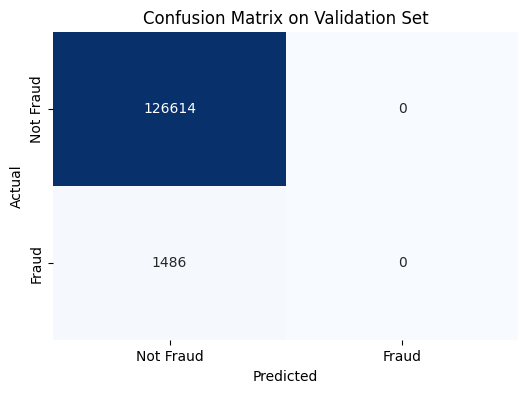


Test Accuracy: 0.9827

Test Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99     35141
           1       0.00      0.00      0.00       620

    accuracy                           0.98     35761
   macro avg       0.49      0.50      0.50     35761
weighted avg       0.97      0.98      0.97     35761



e:\Projects\AI-ML\Fraud_detection\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
e:\Projects\AI-ML\Fraud_detection\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
e:\Projects\AI-ML\Fraud_detection\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


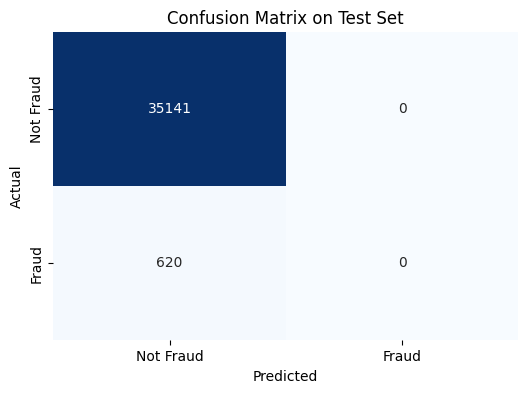


Training Time: 10658.92 seconds


In [23]:
import time
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Separate target from predictors
y_train = upsampled_df['is_fraud']
X_train = upsampled_df.drop('is_fraud', axis=1)

y_test = test_df['is_fraud']
X_test = test_df.drop('is_fraud', axis=1)

y_valid = valid_df['is_fraud']
X_valid = valid_df.drop('is_fraud', axis=1)

# Initialize SVM model
svm_model = SVC(random_state=42)

# Train the model
start_time = time.time()
svm_model.fit(X_train, y_train)
training_time = time.time() - start_time

# Predict on the validation set
y_pred_valid = svm_model.predict(X_valid)

# Evaluate the model on the validation set
valid_accuracy = accuracy_score(y_valid, y_pred_valid)
valid_conf_matrix = confusion_matrix(y_valid, y_pred_valid)
valid_class_report = classification_report(y_valid, y_pred_valid)

# Print the results for the validation set
print(f"Validation Accuracy: {valid_accuracy:.4f}")
print("\nValidation Classification Report:\n", valid_class_report)

# Display confusion matrix using Seaborn heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(valid_conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix on Validation Set')
plt.show()

# Predict on the test set
y_pred_test = svm_model.predict(X_test)

# Evaluate the model on the test set
test_accuracy = accuracy_score(y_test, y_pred_test)
test_conf_matrix = confusion_matrix(y_test, y_pred_test)
test_class_report = classification_report(y_test, y_pred_test)

# Print the results for the test set
print(f"\nTest Accuracy: {test_accuracy:.4f}")
print("\nTest Classification Report:\n", test_class_report)

# Display confusion matrix using Seaborn heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(test_conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix on Test Set')
plt.show()

# Print the training time
print(f"\nTraining Time: {training_time:.2f} seconds")

### ```KNN```

Validation Accuracy: 0.9582

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.97      0.98    126614
           1       0.01      0.02      0.01      1486

    accuracy                           0.96    128100
   macro avg       0.50      0.49      0.49    128100
weighted avg       0.98      0.96      0.97    128100



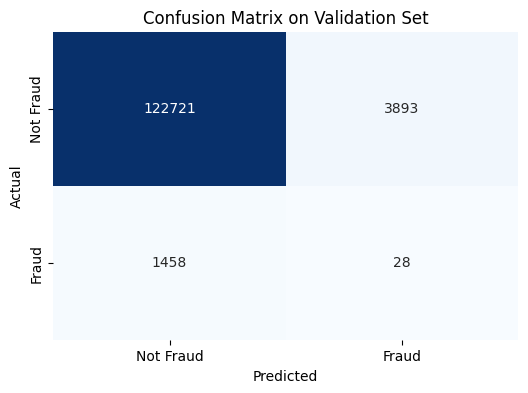


Test Accuracy: 0.9429

Test Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.96      0.97     35141
           1       0.02      0.04      0.03       620

    accuracy                           0.94     35761
   macro avg       0.50      0.50      0.50     35761
weighted avg       0.97      0.94      0.95     35761



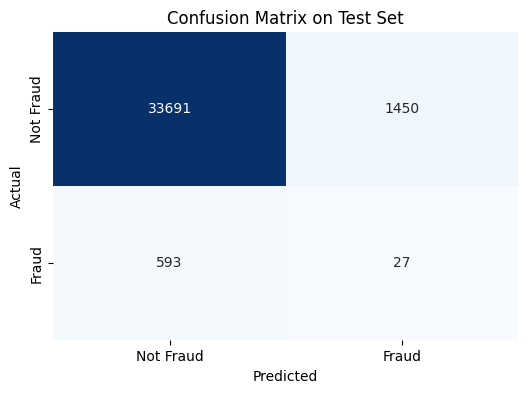


Training Time: 2.00 seconds


In [24]:
import time
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# Separate target from predictors
y_train = upsampled_df['is_fraud']
X_train = upsampled_df.drop('is_fraud', axis=1)

y_test = test_df['is_fraud']
X_test = test_df.drop('is_fraud', axis=1)

y_valid = valid_df['is_fraud']
X_valid = valid_df.drop('is_fraud', axis=1)

# Initialize KNN model (you can adjust the 'n_neighbors' parameter)
knn_model = KNeighborsClassifier(n_neighbors=5)

# Train the model
start_time = time.time()
knn_model.fit(X_train, y_train)
training_time = time.time() - start_time

# Predict on the validation set
y_pred_valid = knn_model.predict(X_valid)

# Evaluate the model on the validation set
valid_accuracy = accuracy_score(y_valid, y_pred_valid)
valid_conf_matrix = confusion_matrix(y_valid, y_pred_valid)
valid_class_report = classification_report(y_valid, y_pred_valid)

# Print the results for the validation set
print(f"Validation Accuracy: {valid_accuracy:.4f}")
print("\nValidation Classification Report:\n", valid_class_report)

# Display confusion matrix using Seaborn heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(valid_conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix on Validation Set')
plt.show()

# Predict on the test set
y_pred_test = knn_model.predict(X_test)

# Evaluate the model on the test set
test_accuracy = accuracy_score(y_test, y_pred_test)
test_conf_matrix = confusion_matrix(y_test, y_pred_test)
test_class_report = classification_report(y_test, y_pred_test)

# Print the results for the test set
print(f"\nTest Accuracy: {test_accuracy:.4f}")
print("\nTest Classification Report:\n", test_class_report)

# Display confusion matrix using Seaborn heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(test_conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix on Test Set')
plt.show()

# Print the training time
print(f"\nTraining Time: {training_time:.2f} seconds")

### ```Cat Boost```

0:	learn: 0.3147458	total: 96.2ms	remaining: 57.6s
1:	learn: 0.1880648	total: 177ms	remaining: 53s
2:	learn: 0.1272588	total: 262ms	remaining: 52.1s
3:	learn: 0.0990999	total: 346ms	remaining: 51.6s
4:	learn: 0.0719102	total: 451ms	remaining: 53.6s
5:	learn: 0.0615077	total: 546ms	remaining: 54.1s
6:	learn: 0.0529052	total: 636ms	remaining: 53.9s
7:	learn: 0.0489882	total: 715ms	remaining: 52.9s
8:	learn: 0.0429433	total: 812ms	remaining: 53.3s
9:	learn: 0.0407386	total: 896ms	remaining: 52.9s
10:	learn: 0.0387550	total: 987ms	remaining: 52.9s
11:	learn: 0.0371884	total: 1.06s	remaining: 52s
12:	learn: 0.0363870	total: 1.15s	remaining: 51.8s
13:	learn: 0.0348423	total: 1.24s	remaining: 51.8s
14:	learn: 0.0327471	total: 1.33s	remaining: 51.9s
15:	learn: 0.0297830	total: 1.41s	remaining: 51.6s
16:	learn: 0.0280713	total: 1.5s	remaining: 51.5s
17:	learn: 0.0275236	total: 1.58s	remaining: 51s
18:	learn: 0.0254129	total: 1.68s	remaining: 51.3s
19:	learn: 0.0242626	total: 1.77s	remaining: 51

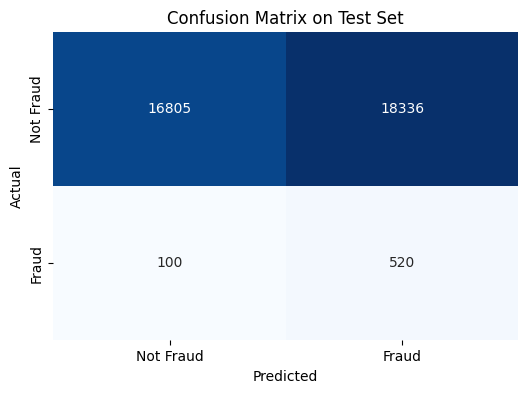

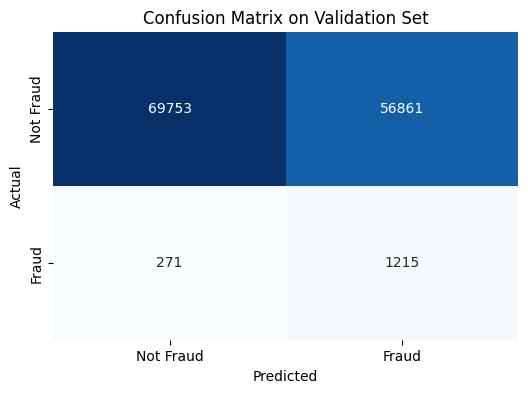


Test Set Evaluation:
Accuracy: 0.4844663180559828

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.48      0.65     35141
           1       0.03      0.84      0.05       620

    accuracy                           0.48     35761
   macro avg       0.51      0.66      0.35     35761
weighted avg       0.98      0.48      0.64     35761


Validation Set Evaluation:
Accuracy: 0.5540046838407494

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.55      0.71    126614
           1       0.02      0.82      0.04      1486

    accuracy                           0.55    128100
   macro avg       0.51      0.68      0.38    128100
weighted avg       0.98      0.55      0.70    128100



In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Separate target from predictors
y_train = upsampled_df['is_fraud']
X_train = upsampled_df.drop('is_fraud', axis=1)

y_test = test_df['is_fraud']
X_test = test_df.drop('is_fraud', axis=1)

y_valid = valid_df['is_fraud']
X_valid = valid_df.drop('is_fraud', axis=1)

# Fit the model to the training data
model = CatBoostClassifier(iterations=600, learning_rate=0.2, depth=8, loss_function='CrossEntropy')

# Fit the model to the training data
model.fit(X_train, y_train)

# Make predictions on the validation set
val_predictions = model.predict(X_valid)

# Make predictions on the test set
test_predictions = model.predict(X_test)

# Display confusion matrix using Seaborn heatmap for the test set
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, test_predictions), annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix on Test Set')
plt.show()

# Display confusion matrix using Seaborn heatmap for the validation set
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_valid, val_predictions), annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix on Validation Set')
plt.show()

# Evaluate the model on the test set
print("\nTest Set Evaluation:")
print("Accuracy:", accuracy_score(y_test, test_predictions))
print("\nClassification Report:")
print(classification_report(y_test, test_predictions))

# Evaluate the model on the validation set
print("\nValidation Set Evaluation:")
print("Accuracy:", accuracy_score(y_valid, val_predictions))
print("\nClassification Report:")
print(classification_report(y_valid, val_predictions))

### ```Neural Network```

Epoch 1/10
16197/16197 [==============================] - 16s 988us/step - loss: 4.1145 - accuracy: 0.9936 - val_loss: 2.1285 - val_accuracy: 0.5703
Epoch 2/10
16197/16197 [==============================] - 16s 971us/step - loss: 0.0378 - accuracy: 0.9938 - val_loss: 2.2267 - val_accuracy: 0.5703
Epoch 3/10
16197/16197 [==============================] - 16s 980us/step - loss: 0.0378 - accuracy: 0.9938 - val_loss: 2.1294 - val_accuracy: 0.5703
Epoch 4/10
16197/16197 [==============================] - 16s 986us/step - loss: 0.0378 - accuracy: 0.9938 - val_loss: 2.1297 - val_accuracy: 0.5703
Epoch 5/10
16197/16197 [==============================] - 16s 975us/step - loss: 0.0378 - accuracy: 0.9938 - val_loss: 2.2243 - val_accuracy: 0.5703
Epoch 6/10
16197/16197 [==============================] - 16s 978us/step - loss: 0.0378 - accuracy: 0.9938 - val_loss: 2.1530 - val_accuracy: 0.5703
Epoch 7/10
16197/16197 [==============================] - 16s 983us/step - loss: 0.0378 - accuracy: 0.9938

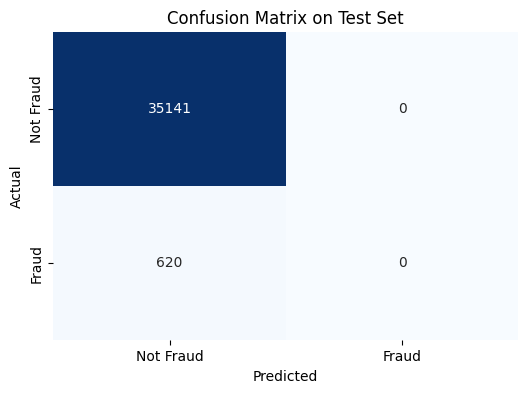


Test Set Evaluation:
Accuracy: 0.9826626772181986

Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99     35141
         1.0       0.00      0.00      0.00       620

    accuracy                           0.98     35761
   macro avg       0.49      0.50      0.50     35761
weighted avg       0.97      0.98      0.97     35761



e:\Projects\AI-ML\Fraud_detection\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
e:\Projects\AI-ML\Fraud_detection\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
e:\Projects\AI-ML\Fraud_detection\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [26]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv1D, Dropout, MaxPooling1D, Flatten, Dense
from tensorflow.keras.optimizers import Adam

# Separate target from predictors
y_train = upsampled_df['is_fraud']
X_train = upsampled_df.drop('is_fraud', axis=1)

y_test = test_df['is_fraud']
X_test = test_df.drop('is_fraud', axis=1)

y_valid = valid_df['is_fraud']
X_valid = valid_df.drop('is_fraud', axis=1)

Number_of_Features = X_train.shape[1]  # Replace X_train with the actual DataFrame you want to use

# Reshape the input features
X_train_reshaped = X_train.values.reshape(-1, 1, Number_of_Features)
X_test_reshaped = X_test.values.reshape(-1, 1, Number_of_Features)

y_train = y_train.values.astype(np.float32)
y_test = y_test.values.astype(np.float32)

# Define the model
model = Sequential()

# Layer 1: Input Layer
model.add(Input(shape=(1, Number_of_Features)))

# Layer 2: Conv1D Layer
model.add(Conv1D(filters=64, kernel_size=1, activation='relu'))

# Layer 3: Conv1D Layer
model.add(Conv1D(filters=64, kernel_size=1, activation='relu'))

# Layer 4: Dropout Layer
model.add(Dropout(0.5))

# Layer 5: MaxPooling1D Layer
model.add(MaxPooling1D(pool_size=1))

# Layer 6: Flatten Layer
model.add(Flatten())

# Layer 7: Dense Layer
model.add(Dense(units=64, activation='relu'))

# Layer 8: Output Layer
model.add(Dense(units=1, activation='sigmoid'))

# Compile the model
final_optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=final_optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train_reshaped, y_train, epochs=10, batch_size=64, validation_split=0.2)

# Evaluate the model on the test set
y_pred_test_prob = model.predict(X_test_reshaped)
y_pred_test = (y_pred_test_prob > 0.5).astype(int)

# Display confusion matrix using Seaborn heatmap for the test set
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred_test), annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix on Test Set')
plt.show()

# Print model evaluation metrics on the test set
print("\nTest Set Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_pred_test))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_test))

### ```Lgboost```

[LightGBM] [Info] Number of positive: 117794, number of negative: 1177944
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006745 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2799
[LightGBM] [Info] Number of data points in the train set: 1295738, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.090909 -> initscore=-2.302588
[LightGBM] [Info] Start training from score -2.302588


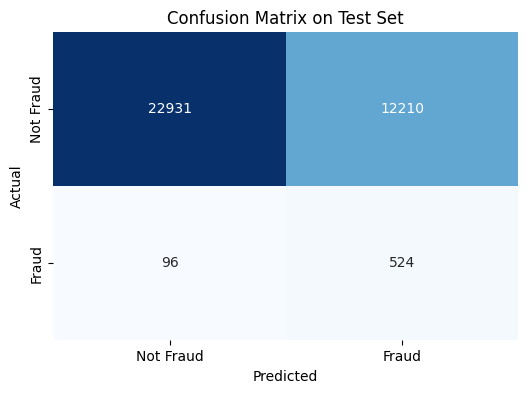

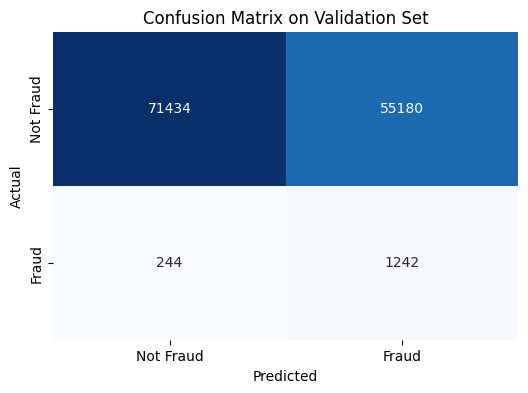


Test Set Evaluation:
Accuracy: 0.6558821062050838

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.65      0.79     35141
           1       0.04      0.85      0.08       620

    accuracy                           0.66     35761
   macro avg       0.52      0.75      0.43     35761
weighted avg       0.98      0.66      0.78     35761


Validation Set Evaluation:
Accuracy: 0.5673380171740827

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.56      0.72    126614
           1       0.02      0.84      0.04      1486

    accuracy                           0.57    128100
   macro avg       0.51      0.70      0.38    128100
weighted avg       0.99      0.57      0.71    128100



In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Separate target from predictors
y_train_copy = upsampled_df['is_fraud'].copy()
X_train_copy = upsampled_df.drop('is_fraud', axis=1).copy()

y_test_copy = test_df['is_fraud'].copy()
X_test_copy = test_df.drop('is_fraud', axis=1).copy()

y_valid_copy = valid_df['is_fraud'].copy()
X_valid_copy = valid_df.drop('is_fraud', axis=1).copy()

# Remove special characters from feature names
X_train_copy.columns = ["".join(c if c.isalnum() else "_" for c in str(x)) for x in X_train_copy.columns]
X_test_copy.columns = ["".join(c if c.isalnum() else "_" for c in str(x)) for x in X_test_copy.columns]
X_valid_copy.columns = ["".join(c if c.isalnum() else "_" for c in str(x)) for x in X_valid_copy.columns]

# Create a LightGBM classifier
lgb_classifier = lgb.LGBMClassifier(random_state=42)

# Fit the model on the training data
lgb_classifier.fit(X_train_copy, y_train_copy)

# Predictions on the test set
y_pred_test = lgb_classifier.predict(X_test_copy)

# Predictions on the validation set
y_pred_valid = lgb_classifier.predict(X_valid_copy)

# Display confusion matrix using Seaborn heatmap for the test set
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test_copy, y_pred_test), annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix on Test Set')
plt.show()

# Display confusion matrix using Seaborn heatmap for the validation set
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_valid_copy, y_pred_valid), annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix on Validation Set')
plt.show()

# Evaluate the model on the test set
print("\nTest Set Evaluation:")
print("Accuracy:", accuracy_score(y_test_copy, y_pred_test))
print("\nClassification Report:")
print(classification_report(y_test_copy, y_pred_test))

# Evaluate the model on the validation set
print("\nValidation Set Evaluation:")
print("Accuracy:", accuracy_score(y_valid_copy, y_pred_valid))
print("\nClassification Report:")
print(classification_report(y_valid_copy, y_pred_valid))

### ```Random Forest```

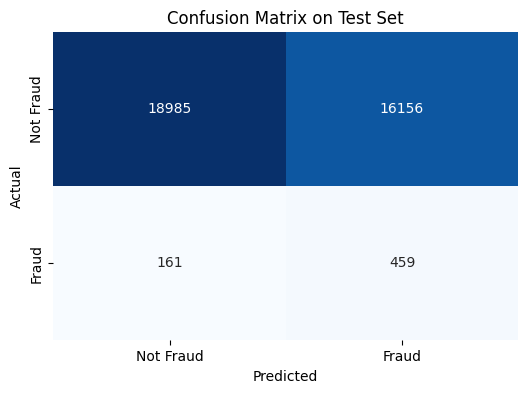

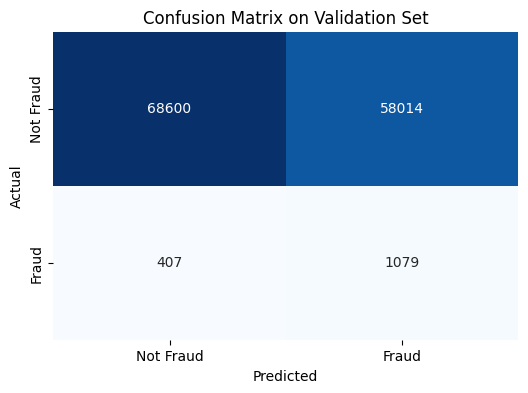


Test Set Evaluation:
Accuracy: 0.5437208131763653

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.54      0.70     35141
           1       0.03      0.74      0.05       620

    accuracy                           0.54     35761
   macro avg       0.51      0.64      0.38     35761
weighted avg       0.97      0.54      0.69     35761


Validation Set Evaluation:
Accuracy: 0.5439422326307572

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.54      0.70    126614
           1       0.02      0.73      0.04      1486

    accuracy                           0.54    128100
   macro avg       0.51      0.63      0.37    128100
weighted avg       0.98      0.54      0.69    128100



In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Separate target from predictors
y_train = upsampled_df['is_fraud']
X_train = upsampled_df.drop('is_fraud', axis=1)

y_test = test_df['is_fraud']
X_test = test_df.drop('is_fraud', axis=1)

y_valid = valid_df['is_fraud']
X_valid = valid_df.drop('is_fraud', axis=1)

# Create a Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Fit the model on the training data
rf_classifier.fit(X_train, y_train)

# Predictions on the test set
y_pred_test = rf_classifier.predict(X_test)

# Predictions on the validation set
y_pred_valid = rf_classifier.predict(X_valid)

# Display confusion matrix using Seaborn heatmap for the test set
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred_test), annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix on Test Set')
plt.show()

# Display confusion matrix using Seaborn heatmap for the validation set
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_valid, y_pred_valid), annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix on Validation Set')
plt.show()

# Evaluate the model on the test set
print("\nTest Set Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_pred_test))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_test))

# Evaluate the model on the validation set
print("\nValidation Set Evaluation:")
print("Accuracy:", accuracy_score(y_valid, y_pred_valid))
print("\nClassification Report:")
print(classification_report(y_valid, y_pred_valid))

### ```AdaBoost```

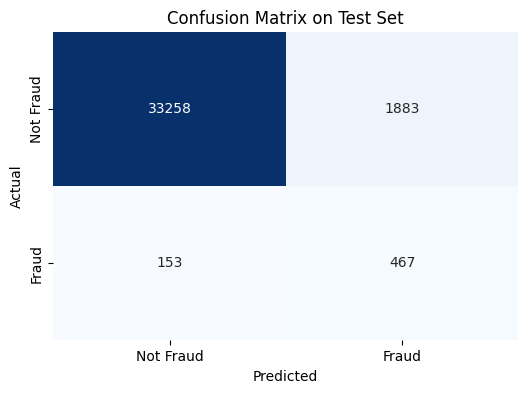


Accuracy on the test set: 94.31%

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.95      0.97     35141
           1       0.20      0.75      0.31       620

    accuracy                           0.94     35761
   macro avg       0.60      0.85      0.64     35761
weighted avg       0.98      0.94      0.96     35761



In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Separate target from predictors
y_train = upsampled_df['is_fraud']
X_train = upsampled_df.drop('is_fraud', axis=1)

y_test = test_df['is_fraud']
X_test = test_df.drop('is_fraud', axis=1)

y_valid = valid_df['is_fraud']
X_valid = valid_df.drop('is_fraud', axis=1)

adaboost_model = AdaBoostClassifier(n_estimators=30, algorithm='SAMME', random_state=20)

# Fit the model on the training data
adaboost_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = adaboost_model.predict(X_test)

# Display confusion matrix using Seaborn heatmap for the test set
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix on Test Set')
plt.show()

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy on the test set: {accuracy:.2%}")

# Display classification report
classification_rep = classification_report(y_test, y_pred)
print("\nClassification Report:")
print(classification_rep)

## **Upsampling using SMOT 20% on Training set**

#### ```Rationale for Applying 20% SMOTE to Credit Card Fraud Detection Dataset```

In addition to the initial 10% SMOTE applied to the credit card fraud detection dataset, we further evaluated the impact of increasing the minority class representation to 20%. This decision was driven by the following considerations:

1. **Addressing Persistent Imbalance:** Even after applying 10% SMOTE, the class imbalance remained noticeable, with fraudulent transactions still constituting a small fraction of the overall data.

2. **Potential for Improved Detection:** A higher SMOTE ratio could further enhance the model's ability to identify fraudulent transactions, particularly those with subtle or atypical patterns.

3. **Monitoring Model Performance:** By applying 20% SMOTE, we could assess whether a more aggressive minority class oversampling strategy would yield significant improvements in fraud detection accuracy.

4. **Risk of Overfitting:** While increased minority class representation can improve model performance, it also carries the risk of overfitting. Closely monitoring the model's performance on unseen data was crucial to ensure that the benefits of SMOTE outweighed the potential drawbacks.

In summary, applying 20% SMOTE was an attempt to further mitigate the class imbalance and potentially improve fraud detection accuracy. However, careful monitoring of the model's performance on unseen data was essential to prevent overfitting and ensure that the benefits of SMOTE were not outweighed by the potential risks.

In [7]:
upsampled_df_20 = smote(train_df, 0.2)

Original class distribution: is_fraud
0    1177944
1       7431
Name: count, dtype: int64
Resampled class distribution: is_fraud
0    1177944
1     235588
Name: count, dtype: int64


## **Model Implementation After Upsampling using SMOT**

### ```XGBoost```

e:\Projects\AI-ML\Fraud_detection\.venv\lib\site-packages\xgboost\core.py:160: UserWarning: [00:40:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)
e:\Projects\AI-ML\Fraud_detection\.venv\lib\site-packages\xgboost\core.py:160: UserWarning: [00:41:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample", "tree_method" } are not used.

  warnings.warn(smsg, UserWarning)
e:\Projects\AI-ML\Fraud_detection\.venv\lib\site-packages\xgboost\core.py:160: UserWarning: [00:41:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676

RandomizedSearchCV took 3509.96 seconds for 100 candidates parameter settings.
Validation Accuracy: 0.5069945355191257
Confusion Matrix (Validation Set):
 [[64053 62561]
 [  593   893]]
Classification Report (Validation Set):
               precision    recall  f1-score   support

           0       0.99      0.51      0.67    126614
           1       0.01      0.60      0.03      1486

    accuracy                           0.51    128100
   macro avg       0.50      0.55      0.35    128100
weighted avg       0.98      0.51      0.66    128100

Test Accuracy: 0.5104723022286849
Confusion Matrix (Test Set):
 [[17883 17258]
 [  248   372]]
Classification Report (Test Set):
               precision    recall  f1-score   support

           0       0.99      0.51      0.67     35141
           1       0.02      0.60      0.04       620

    accuracy                           0.51     35761
   macro avg       0.50      0.55      0.36     35761
weighted avg       0.97      0.51      0.66 

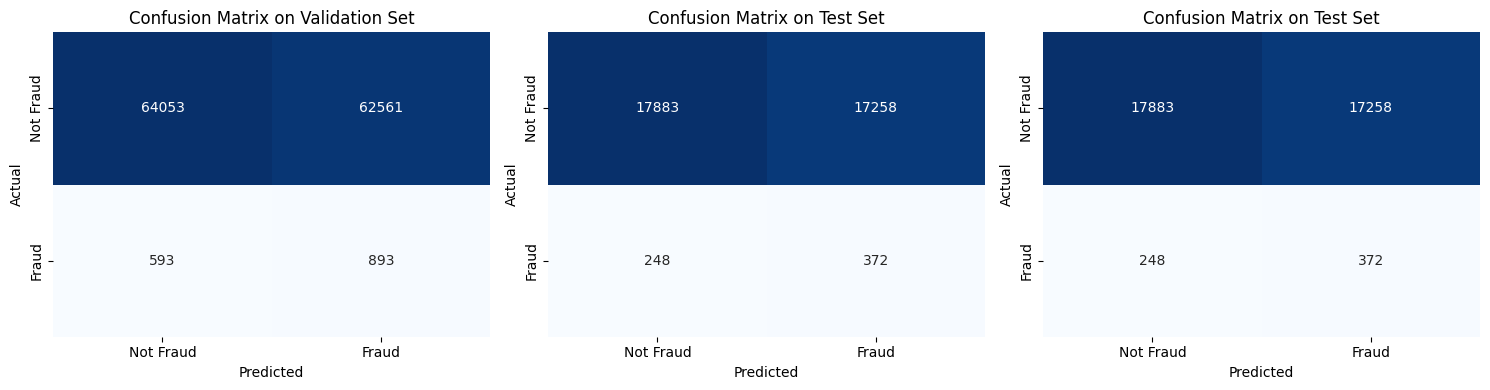

In [12]:
# Separate target from predictors
y_train = upsampled_df_20['is_fraud']
X_train = upsampled_df_20.drop('is_fraud', axis=1)

y_test = test_df['is_fraud']
X_test = test_df.drop('is_fraud', axis=1)

y_valid = valid_df['is_fraud']
X_valid = valid_df.drop('is_fraud', axis=1)

# A parameter grid for XGBoost
params = {
    'n_estimators': [500],
    'min_child_weight': [4, 5],
    'gamma': [i / 10.0 for i in range(3, 6)],
    'subsample': [i / 10.0 for i in range(6, 11)],
    'colsample_bytree': [i / 10.0 for i in range(6, 11)],
    'max_depth': [2, 3, 4, 6, 7],
    'objective': ['binary:logistic'],  # Use binary:logistic for binary classification
    'booster': ['gbtree', 'gblinear'],
    'eval_metric': ['error'],  # Use error for classification tasks
    'eta': [i / 10.0 for i in range(3, 6)],
}

# Set the tree_method to 'gpu_hist' to use GPU acceleration
reg = XGBClassifier(nthread=-1, tree_method='gpu_hist')

# run randomized search
n_iter_search = 100
random_search = RandomizedSearchCV(
    reg, param_distributions=params, n_iter=n_iter_search, cv=5, scoring='accuracy')

start = time.time()
random_search.fit(X_train, y_train)
print("RandomizedSearchCV took %.2f seconds for %d candidates parameter settings." % ((time.time() - start), n_iter_search))

best_classifier = random_search.best_estimator_

# Get predictions on the validation set
y_pred_valid = best_classifier.predict(X_valid)

# Calculate accuracy, confusion matrix, precision, recall, F1 score on the validation set
valid_accuracy = accuracy_score(y_valid, y_pred_valid)
conf_matrix_valid = confusion_matrix(y_valid, y_pred_valid)
classification_rep_valid = classification_report(y_valid, y_pred_valid)

print("Validation Accuracy:", valid_accuracy)
print("Confusion Matrix (Validation Set):\n", conf_matrix_valid)
print("Classification Report (Validation Set):\n", classification_rep_valid)

# Get predictions on the test set
y_pred_test = best_classifier.predict(X_test)

# Calculate accuracy, confusion matrix, precision, recall, F1 score on the test set
test_accuracy = accuracy_score(y_test, y_pred_test)
conf_matrix_test = confusion_matrix(y_test, y_pred_test)
classification_rep_test = classification_report(y_test, y_pred_test)

print("Test Accuracy:", test_accuracy)
print("Confusion Matrix (Test Set):\n", conf_matrix_test)
print("Classification Report (Test Set):\n", classification_rep_test)

# Display confusion matrices using heatmaps
plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
sns.heatmap(conf_matrix_valid, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix on Validation Set')

plt.subplot(1, 3, 2)
sns.heatmap(conf_matrix_test, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix on Test Set')

plt.subplot(1, 3, 3)
sns.heatmap(conf_matrix_test, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix on Test Set')

plt.tight_layout()
plt.show()

### ```Decision Tree```

Validation Accuracy: 0.4400

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.44      0.61    126614
           1       0.01      0.63      0.03      1486

    accuracy                           0.44    128100
   macro avg       0.50      0.53      0.32    128100
weighted avg       0.98      0.44      0.60    128100



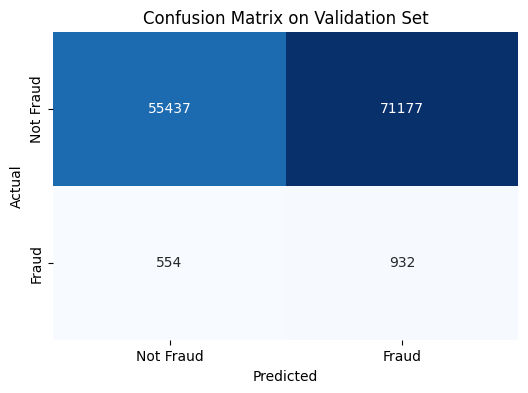


Test Accuracy: 0.4910

Test Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.49      0.65     35141
           1       0.02      0.72      0.05       620

    accuracy                           0.49     35761
   macro avg       0.51      0.60      0.35     35761
weighted avg       0.97      0.49      0.64     35761



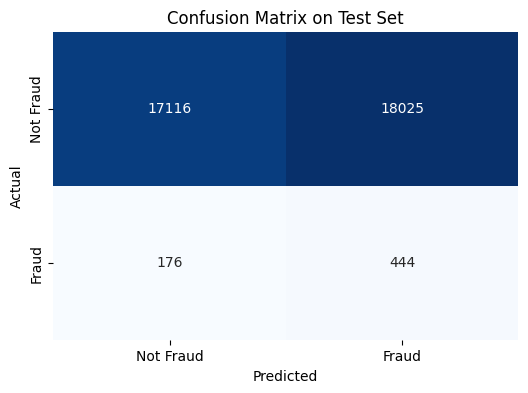


Training Time: 16.08 seconds


In [13]:
import time
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Separate target from predictors
y_train = upsampled_df_20['is_fraud']
X_train = upsampled_df_20.drop('is_fraud', axis=1)

y_test = test_df['is_fraud']
X_test = test_df.drop('is_fraud', axis=1)

y_valid = valid_df['is_fraud']
X_valid = valid_df.drop('is_fraud', axis=1)

# Initialize Decision Tree model
dt_model = DecisionTreeClassifier(random_state=42)

# Train the model
start_time = time.time()
dt_model.fit(X_train, y_train)
training_time = time.time() - start_time

# Predict on the validation set
y_pred_valid = dt_model.predict(X_valid)

# Evaluate the model on the validation set
valid_accuracy = accuracy_score(y_valid, y_pred_valid)
valid_conf_matrix = confusion_matrix(y_valid, y_pred_valid)
valid_class_report = classification_report(y_valid, y_pred_valid)

# Print the results for the validation set
print(f"Validation Accuracy: {valid_accuracy:.4f}")
print("\nValidation Classification Report:\n", valid_class_report)

# Display confusion matrix using Seaborn heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(valid_conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix on Validation Set')
plt.show()

# Predict on the test set
y_pred_test = dt_model.predict(X_test)

# Evaluate the model on the test set
test_accuracy = accuracy_score(y_test, y_pred_test)
test_conf_matrix = confusion_matrix(y_test, y_pred_test)
test_class_report = classification_report(y_test, y_pred_test)

# Print the results for the test set
print(f"\nTest Accuracy: {test_accuracy:.4f}")
print("\nTest Classification Report:\n", test_class_report)

# Display confusion matrix using Seaborn heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(test_conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix on Test Set')
plt.show()

# Print the training time
print(f"\nTraining Time: {training_time:.2f} seconds")

### ```SVM```

Validation Accuracy: 0.9884

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99    126614
           1       0.00      0.00      0.00      1486

    accuracy                           0.99    128100
   macro avg       0.49      0.50      0.50    128100
weighted avg       0.98      0.99      0.98    128100



e:\Projects\AI-ML\Fraud_detection\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
e:\Projects\AI-ML\Fraud_detection\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
e:\Projects\AI-ML\Fraud_detection\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


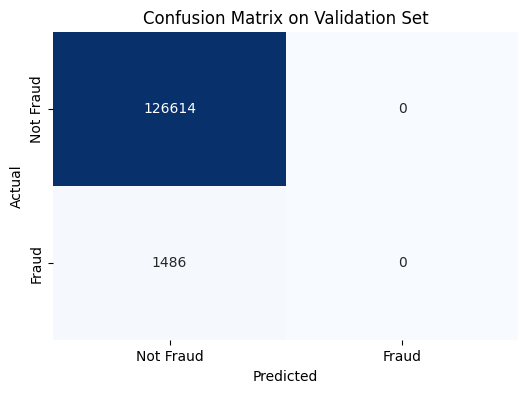


Test Accuracy: 0.9827

Test Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99     35141
           1       0.00      0.00      0.00       620

    accuracy                           0.98     35761
   macro avg       0.49      0.50      0.50     35761
weighted avg       0.97      0.98      0.97     35761



e:\Projects\AI-ML\Fraud_detection\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
e:\Projects\AI-ML\Fraud_detection\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
e:\Projects\AI-ML\Fraud_detection\.venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


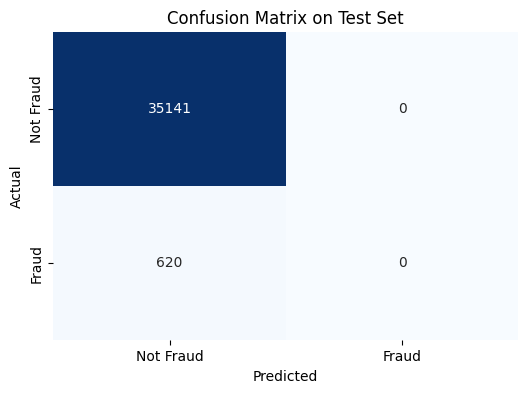


Training Time: 19225.92 seconds


In [14]:
import time
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Separate target from predictors
y_train = upsampled_df_20['is_fraud']
X_train = upsampled_df_20.drop('is_fraud', axis=1)

y_test = test_df['is_fraud']
X_test = test_df.drop('is_fraud', axis=1)

y_valid = valid_df['is_fraud']
X_valid = valid_df.drop('is_fraud', axis=1)

# Initialize SVM model
svm_model = SVC(random_state=42)

# Train the model
start_time = time.time()
svm_model.fit(X_train, y_train)
training_time = time.time() - start_time

# Predict on the validation set
y_pred_valid = svm_model.predict(X_valid)

# Evaluate the model on the validation set
valid_accuracy = accuracy_score(y_valid, y_pred_valid)
valid_conf_matrix = confusion_matrix(y_valid, y_pred_valid)
valid_class_report = classification_report(y_valid, y_pred_valid)

# Print the results for the validation set
print(f"Validation Accuracy: {valid_accuracy:.4f}")
print("\nValidation Classification Report:\n", valid_class_report)

# Display confusion matrix using Seaborn heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(valid_conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix on Validation Set')
plt.show()

# Predict on the test set
y_pred_test = svm_model.predict(X_test)

# Evaluate the model on the test set
test_accuracy = accuracy_score(y_test, y_pred_test)
test_conf_matrix = confusion_matrix(y_test, y_pred_test)
test_class_report = classification_report(y_test, y_pred_test)

# Print the results for the test set
print(f"\nTest Accuracy: {test_accuracy:.4f}")
print("\nTest Classification Report:\n", test_class_report)

# Display confusion matrix using Seaborn heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(test_conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix on Test Set')
plt.show()

# Print the training time
print(f"\nTraining Time: {training_time:.2f} seconds")

### ```KNN```

Validation Accuracy: 0.9442

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.95      0.97    126614
           1       0.01      0.04      0.01      1486

    accuracy                           0.94    128100
   macro avg       0.50      0.50      0.49    128100
weighted avg       0.98      0.94      0.96    128100



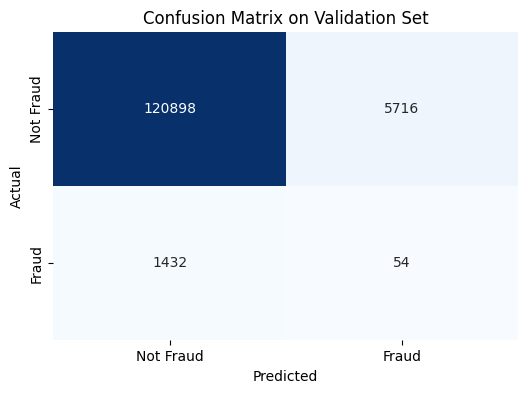


Test Accuracy: 0.9268

Test Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.94      0.96     35141
           1       0.01      0.05      0.02       620

    accuracy                           0.93     35761
   macro avg       0.50      0.49      0.49     35761
weighted avg       0.97      0.93      0.95     35761



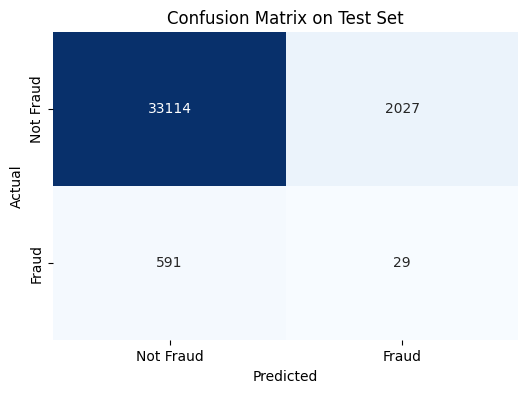


Training Time: 2.32 seconds


In [15]:
import time
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# Separate target from predictors
y_train = upsampled_df_20['is_fraud']
X_train = upsampled_df_20.drop('is_fraud', axis=1)

y_test = test_df['is_fraud']
X_test = test_df.drop('is_fraud', axis=1)

y_valid = valid_df['is_fraud']
X_valid = valid_df.drop('is_fraud', axis=1)

# Initialize KNN model (you can adjust the 'n_neighbors' parameter)
knn_model = KNeighborsClassifier(n_neighbors=5)

# Train the model
start_time = time.time()
knn_model.fit(X_train, y_train)
training_time = time.time() - start_time

# Predict on the validation set
y_pred_valid = knn_model.predict(X_valid)

# Evaluate the model on the validation set
valid_accuracy = accuracy_score(y_valid, y_pred_valid)
valid_conf_matrix = confusion_matrix(y_valid, y_pred_valid)
valid_class_report = classification_report(y_valid, y_pred_valid)

# Print the results for the validation set
print(f"Validation Accuracy: {valid_accuracy:.4f}")
print("\nValidation Classification Report:\n", valid_class_report)

# Display confusion matrix using Seaborn heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(valid_conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix on Validation Set')
plt.show()

# Predict on the test set
y_pred_test = knn_model.predict(X_test)

# Evaluate the model on the test set
test_accuracy = accuracy_score(y_test, y_pred_test)
test_conf_matrix = confusion_matrix(y_test, y_pred_test)
test_class_report = classification_report(y_test, y_pred_test)

# Print the results for the test set
print(f"\nTest Accuracy: {test_accuracy:.4f}")
print("\nTest Classification Report:\n", test_class_report)

# Display confusion matrix using Seaborn heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(test_conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix on Test Set')
plt.show()

# Print the training time
print(f"\nTraining Time: {training_time:.2f} seconds")

### ```Cat Boost```

0:	learn: 0.3415416	total: 279ms	remaining: 2m 47s
1:	learn: 0.2134151	total: 380ms	remaining: 1m 53s
2:	learn: 0.1465457	total: 477ms	remaining: 1m 34s
3:	learn: 0.1153869	total: 582ms	remaining: 1m 26s
4:	learn: 0.0928732	total: 685ms	remaining: 1m 21s
5:	learn: 0.0830699	total: 784ms	remaining: 1m 17s
6:	learn: 0.0737084	total: 903ms	remaining: 1m 16s
7:	learn: 0.0650224	total: 992ms	remaining: 1m 13s
8:	learn: 0.0588337	total: 1.08s	remaining: 1m 10s
9:	learn: 0.0559441	total: 1.18s	remaining: 1m 9s
10:	learn: 0.0522920	total: 1.28s	remaining: 1m 8s
11:	learn: 0.0482748	total: 1.37s	remaining: 1m 7s
12:	learn: 0.0452612	total: 1.47s	remaining: 1m 6s
13:	learn: 0.0438452	total: 1.55s	remaining: 1m 5s
14:	learn: 0.0414173	total: 1.66s	remaining: 1m 4s
15:	learn: 0.0377194	total: 1.75s	remaining: 1m 3s
16:	learn: 0.0355729	total: 1.86s	remaining: 1m 3s
17:	learn: 0.0344559	total: 1.95s	remaining: 1m 3s
18:	learn: 0.0323358	total: 2.06s	remaining: 1m 2s
19:	learn: 0.0318826	total: 2.16

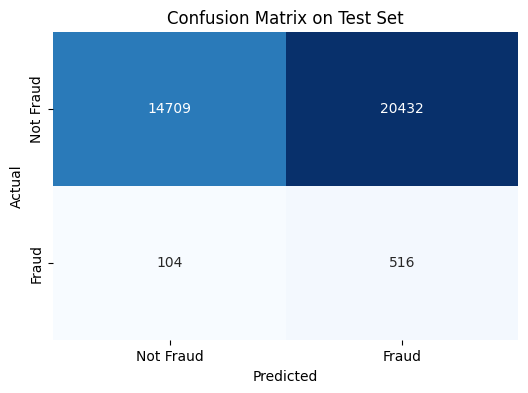

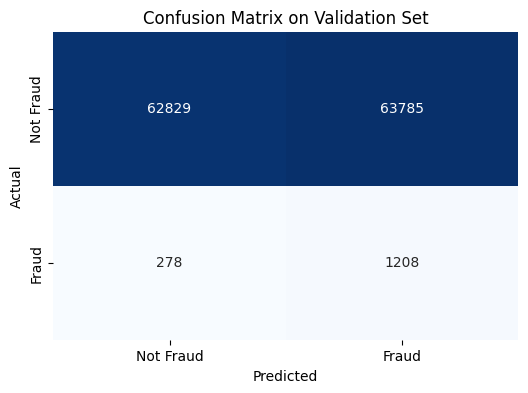


Test Set Evaluation:
Accuracy: 0.42574312798859093

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.42      0.59     35141
           1       0.02      0.83      0.05       620

    accuracy                           0.43     35761
   macro avg       0.51      0.63      0.32     35761
weighted avg       0.98      0.43      0.58     35761


Validation Set Evaluation:
Accuracy: 0.4998985167837627

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.50      0.66    126614
           1       0.02      0.81      0.04      1486

    accuracy                           0.50    128100
   macro avg       0.51      0.65      0.35    128100
weighted avg       0.98      0.50      0.66    128100



In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Separate target from predictors
y_train = upsampled_df_20['is_fraud']
X_train = upsampled_df_20.drop('is_fraud', axis=1)

y_test = test_df['is_fraud']
X_test = test_df.drop('is_fraud', axis=1)

y_valid = valid_df['is_fraud']
X_valid = valid_df.drop('is_fraud', axis=1)

# Fit the model to the training data
model = CatBoostClassifier(iterations=600, learning_rate=0.2, depth=8, loss_function='CrossEntropy')

# Fit the model to the training data
model.fit(X_train, y_train)

# Make predictions on the validation set
val_predictions = model.predict(X_valid)

# Make predictions on the test set
test_predictions = model.predict(X_test)

# Display confusion matrix using Seaborn heatmap for the test set
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, test_predictions), annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix on Test Set')
plt.show()

# Display confusion matrix using Seaborn heatmap for the validation set
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_valid, val_predictions), annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix on Validation Set')
plt.show()

# Evaluate the model on the test set
print("\nTest Set Evaluation:")
print("Accuracy:", accuracy_score(y_test, test_predictions))
print("\nClassification Report:")
print(classification_report(y_test, test_predictions))

# Evaluate the model on the validation set
print("\nValidation Set Evaluation:")
print("Accuracy:", accuracy_score(y_valid, val_predictions))
print("\nClassification Report:")
print(classification_report(y_valid, val_predictions))

### ```Neural Network```

Epoch 1/10
17670/17670 [==============================] - 19s 1ms/step - loss: 3.5361 - accuracy: 0.9935 - val_loss: 4.0950 - val_accuracy: 0.1918
Epoch 2/10
17670/17670 [==============================] - 17s 970us/step - loss: 0.8719 - accuracy: 0.9936 - val_loss: 4.1680 - val_accuracy: 0.1918
Epoch 3/10
17670/17670 [==============================] - 17s 973us/step - loss: 0.0381 - accuracy: 0.9937 - val_loss: 4.0487 - val_accuracy: 0.1918
Epoch 4/10
17670/17670 [==============================] - 17s 982us/step - loss: 0.0382 - accuracy: 0.9937 - val_loss: 4.0450 - val_accuracy: 0.1918
Epoch 5/10
17670/17670 [==============================] - 17s 977us/step - loss: 0.0718 - accuracy: 0.9937 - val_loss: 4.0337 - val_accuracy: 0.1918
Epoch 6/10
17670/17670 [==============================] - 17s 972us/step - loss: 0.0381 - accuracy: 0.9937 - val_loss: 3.8872 - val_accuracy: 0.1918
Epoch 7/10
17670/17670 [==============================] - 17s 972us/step - loss: 0.0381 - accuracy: 0.9937 -

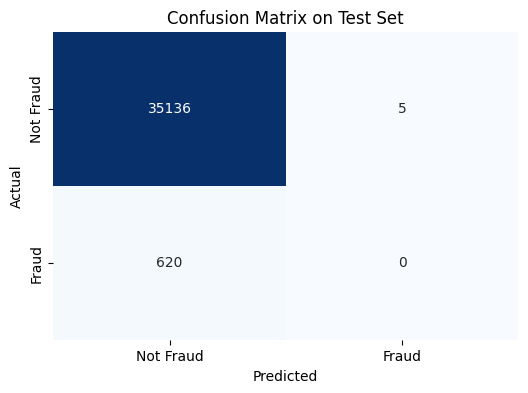


Test Set Evaluation:
Accuracy: 0.9825228600989905

Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99     35141
         1.0       0.00      0.00      0.00       620

    accuracy                           0.98     35761
   macro avg       0.49      0.50      0.50     35761
weighted avg       0.97      0.98      0.97     35761



In [17]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv1D, Dropout, MaxPooling1D, Flatten, Dense
from tensorflow.keras.optimizers import Adam

# Separate target from predictors
y_train = upsampled_df_20['is_fraud']
X_train = upsampled_df_20.drop('is_fraud', axis=1)

y_test = test_df['is_fraud']
X_test = test_df.drop('is_fraud', axis=1)

y_valid = valid_df['is_fraud']
X_valid = valid_df.drop('is_fraud', axis=1)

Number_of_Features = X_train.shape[1]  # Replace X_train with the actual DataFrame you want to use

# Reshape the input features
X_train_reshaped = X_train.values.reshape(-1, 1, Number_of_Features)
X_test_reshaped = X_test.values.reshape(-1, 1, Number_of_Features)

y_train = y_train.values.astype(np.float32)
y_test = y_test.values.astype(np.float32)

# Define the model
model = Sequential()

# Layer 1: Input Layer
model.add(Input(shape=(1, Number_of_Features)))

# Layer 2: Conv1D Layer
model.add(Conv1D(filters=64, kernel_size=1, activation='relu'))

# Layer 3: Conv1D Layer
model.add(Conv1D(filters=64, kernel_size=1, activation='relu'))

# Layer 4: Dropout Layer
model.add(Dropout(0.5))

# Layer 5: MaxPooling1D Layer
model.add(MaxPooling1D(pool_size=1))

# Layer 6: Flatten Layer
model.add(Flatten())

# Layer 7: Dense Layer
model.add(Dense(units=64, activation='relu'))

# Layer 8: Output Layer
model.add(Dense(units=1, activation='sigmoid'))

# Compile the model
final_optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=final_optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train_reshaped, y_train, epochs=10, batch_size=64, validation_split=0.2)

# Evaluate the model on the test set
y_pred_test_prob = model.predict(X_test_reshaped)
y_pred_test = (y_pred_test_prob > 0.5).astype(int)

# Display confusion matrix using Seaborn heatmap for the test set
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred_test), annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix on Test Set')
plt.show()

# Print model evaluation metrics on the test set
print("\nTest Set Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_pred_test))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_test))

### ```Lgboost```

[LightGBM] [Info] Number of positive: 235588, number of negative: 1177944
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008258 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2800
[LightGBM] [Info] Number of data points in the train set: 1413532, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166666 -> initscore=-1.609441
[LightGBM] [Info] Start training from score -1.609441


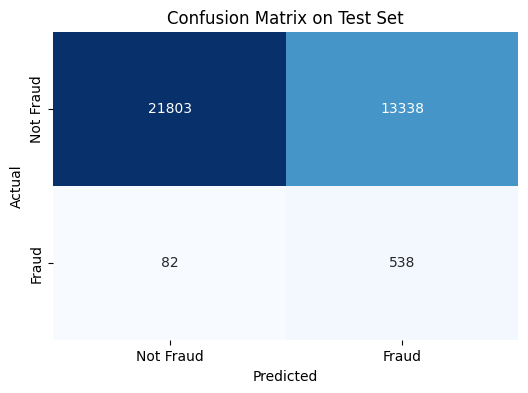

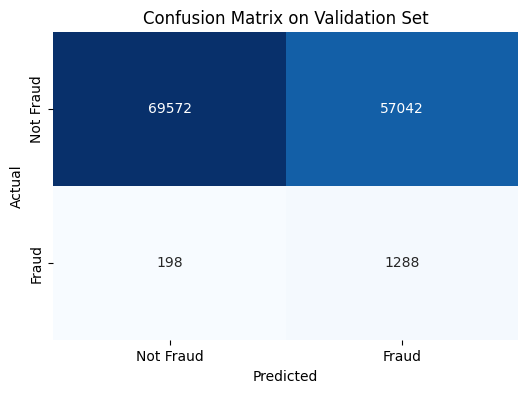


Test Set Evaluation:
Accuracy: 0.6247308520455245

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.62      0.76     35141
           1       0.04      0.87      0.07       620

    accuracy                           0.62     35761
   macro avg       0.52      0.74      0.42     35761
weighted avg       0.98      0.62      0.75     35761


Validation Set Evaluation:
Accuracy: 0.5531615925058548

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.55      0.71    126614
           1       0.02      0.87      0.04      1486

    accuracy                           0.55    128100
   macro avg       0.51      0.71      0.38    128100
weighted avg       0.99      0.55      0.70    128100



In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Separate target from predictors
y_train_copy = upsampled_df_20['is_fraud'].copy()
X_train_copy = upsampled_df_20.drop('is_fraud', axis=1).copy()

y_test_copy = test_df['is_fraud'].copy()
X_test_copy = test_df.drop('is_fraud', axis=1).copy()

y_valid_copy = valid_df['is_fraud'].copy()
X_valid_copy = valid_df.drop('is_fraud', axis=1).copy()

# Remove special characters from feature names
X_train_copy.columns = ["".join(c if c.isalnum() else "_" for c in str(x)) for x in X_train_copy.columns]
X_test_copy.columns = ["".join(c if c.isalnum() else "_" for c in str(x)) for x in X_test_copy.columns]
X_valid_copy.columns = ["".join(c if c.isalnum() else "_" for c in str(x)) for x in X_valid_copy.columns]

# Create a LightGBM classifier
lgb_classifier = lgb.LGBMClassifier(random_state=42)

# Fit the model on the training data
lgb_classifier.fit(X_train_copy, y_train_copy)

# Predictions on the test set
y_pred_test = lgb_classifier.predict(X_test_copy)

# Predictions on the validation set
y_pred_valid = lgb_classifier.predict(X_valid_copy)

# Display confusion matrix using Seaborn heatmap for the test set
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test_copy, y_pred_test), annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix on Test Set')
plt.show()

# Display confusion matrix using Seaborn heatmap for the validation set
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_valid_copy, y_pred_valid), annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix on Validation Set')
plt.show()

# Evaluate the model on the test set
print("\nTest Set Evaluation:")
print("Accuracy:", accuracy_score(y_test_copy, y_pred_test))
print("\nClassification Report:")
print(classification_report(y_test_copy, y_pred_test))

# Evaluate the model on the validation set
print("\nValidation Set Evaluation:")
print("Accuracy:", accuracy_score(y_valid_copy, y_pred_valid))
print("\nClassification Report:")
print(classification_report(y_valid_copy, y_pred_valid))

### ```Random Forest```

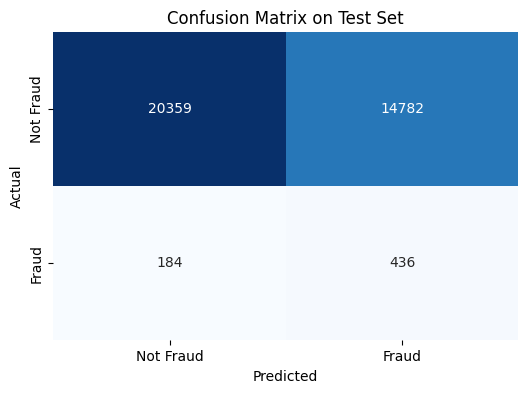

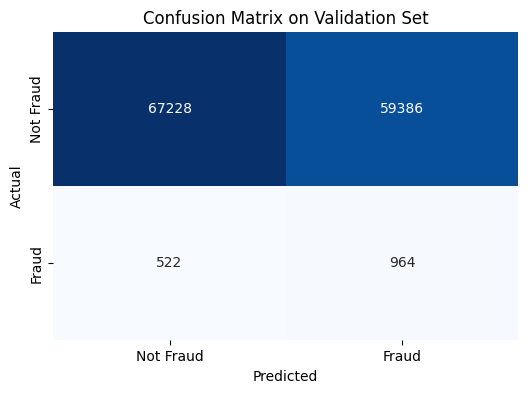


Test Set Evaluation:
Accuracy: 0.5814993987863875

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.58      0.73     35141
           1       0.03      0.70      0.06       620

    accuracy                           0.58     35761
   macro avg       0.51      0.64      0.39     35761
weighted avg       0.97      0.58      0.72     35761


Validation Set Evaluation:
Accuracy: 0.5323341139734582

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.53      0.69    126614
           1       0.02      0.65      0.03      1486

    accuracy                           0.53    128100
   macro avg       0.50      0.59      0.36    128100
weighted avg       0.98      0.53      0.68    128100



In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Separate target from predictors
y_train = upsampled_df_20['is_fraud']
X_train = upsampled_df_20.drop('is_fraud', axis=1)

y_test = test_df['is_fraud']
X_test = test_df.drop('is_fraud', axis=1)

y_valid = valid_df['is_fraud']
X_valid = valid_df.drop('is_fraud', axis=1)

# Create a Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Fit the model on the training data
rf_classifier.fit(X_train, y_train)

# Predictions on the test set
y_pred_test = rf_classifier.predict(X_test)

# Predictions on the validation set
y_pred_valid = rf_classifier.predict(X_valid)

# Display confusion matrix using Seaborn heatmap for the test set
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred_test), annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix on Test Set')
plt.show()

# Display confusion matrix using Seaborn heatmap for the validation set
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_valid, y_pred_valid), annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix on Validation Set')
plt.show()

# Evaluate the model on the test set
print("\nTest Set Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_pred_test))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_test))

# Evaluate the model on the validation set
print("\nValidation Set Evaluation:")
print("Accuracy:", accuracy_score(y_valid, y_pred_valid))
print("\nClassification Report:")
print(classification_report(y_valid, y_pred_valid))

### ```AdaBoost```

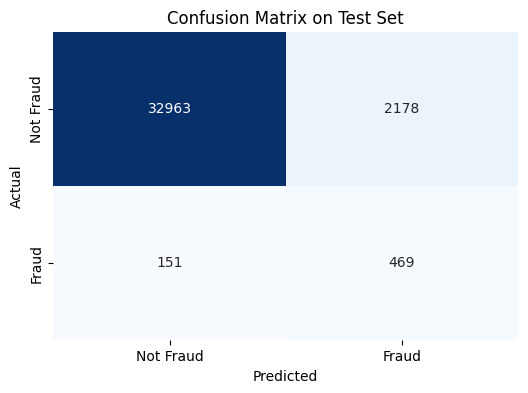


Accuracy on the test set: 93.49%

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.94      0.97     35141
           1       0.18      0.76      0.29       620

    accuracy                           0.93     35761
   macro avg       0.59      0.85      0.63     35761
weighted avg       0.98      0.93      0.95     35761



In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Separate target from predictors
y_train = upsampled_df_20['is_fraud']
X_train = upsampled_df_20.drop('is_fraud', axis=1)

y_test = test_df['is_fraud']
X_test = test_df.drop('is_fraud', axis=1)

y_valid = valid_df['is_fraud']
X_valid = valid_df.drop('is_fraud', axis=1)

adaboost_model = AdaBoostClassifier(n_estimators=30, algorithm='SAMME', random_state=20)

# Fit the model on the training data
adaboost_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = adaboost_model.predict(X_test)

# Display confusion matrix using Seaborn heatmap for the test set
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix on Test Set')
plt.show()

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy on the test set: {accuracy:.2%}")

# Display classification report
classification_rep = classification_report(y_test, y_pred)
print("\nClassification Report:")
print(classification_rep)

### ```Logit Regression For R&D Purpose: Checking up thresholds```

In the presented code, Logistic Regression is employed as a predictive model for fraud detection. The Logistic Regression model is trained on a filtered dataset, with the target variable 'is_fraud' separated from the predictor variables. The utilization of Logistic Regression in fraud detection is motivated by its interpretability, simplicity, and efficiency, making it well-suited for binary classification tasks. The code further explores the impact of different probability thresholds on model performance, specifically focusing on recall as a metric. By varying the threshold, the code aims to find a balance that maximizes the identification of fraudulent transactions (true positives) while minimizing false negatives. This approach is crucial in fraud detection, where the emphasis is often on identifying as many actual fraud cases as possible. The visual representation of confusion matrices at different thresholds provides valuable insights into the trade-off between precision and recall, aiding in the fine-tuning of the model for optimal fraud detection performance. Overall, Logistic Regression, coupled with threshold tuning, contributes to a pragmatic and interpretable solution for identifying fraudulent activities in a given dataset.

In [14]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    # draw heatmap of confusion matrix
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    # draw ticks for each class
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    # add labels for x and y axis
    plt.xlabel('Predicted label')
    plt.ylabel('True label')

    plt.show()

Recall metric in the testing dataset:  0.5483870967741935


e:\Projects\AI-ML\Fraud_detection\.venv\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


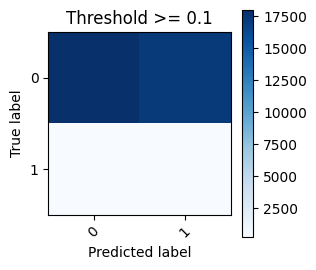

Recall metric in the testing dataset:  0.5387096774193548


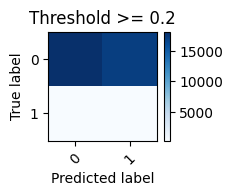

Recall metric in the testing dataset:  0.5290322580645161


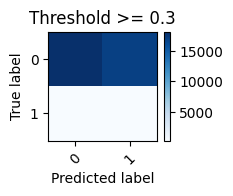

Recall metric in the testing dataset:  0.5241935483870968


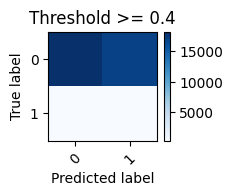

Recall metric in the testing dataset:  0.5225806451612903


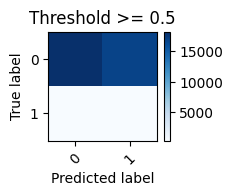

Recall metric in the testing dataset:  0.5209677419354839


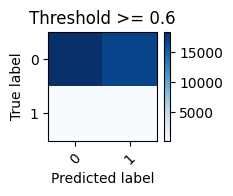

Recall metric in the testing dataset:  0.5177419354838709


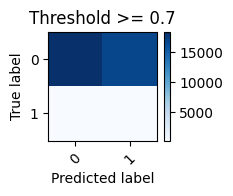

Recall metric in the testing dataset:  0.5161290322580645


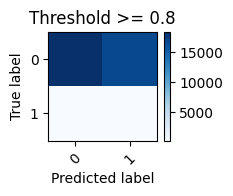

Recall metric in the testing dataset:  0.5112903225806451


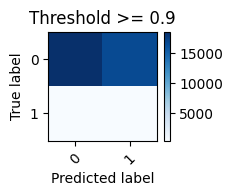

In [15]:
from sklearn.linear_model import LogisticRegression

# Separate target from predictors
y_train = filtered_dataframe['is_fraud']
X_train = filtered_dataframe.drop('is_fraud', axis=1)

y_test = test_df['is_fraud']
X_test = test_df.drop('is_fraud', axis=1)

y_valid = valid_df['is_fraud']
X_valid = valid_df.drop('is_fraud', axis=1)

lr = LogisticRegression(C=0.01, penalty='l1', solver='liblinear')  # Change solver to 'liblinear'
lr.fit(X_train, y_train.values.ravel())
y_pred_proba = lr.predict_proba(X_test.values)

thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

plt.figure(figsize=(10, 10))

j = 1
for i in thresholds:
    y_test_predictions_high_recall = y_pred_proba[:, 1] > i
    
    plt.subplot(3, 3, j)
    j += 1
    
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_test, y_test_predictions_high_recall)
    np.set_printoptions(precision=2)

    print("Recall metric in the testing dataset: ", cnf_matrix[1, 1] / (cnf_matrix[1, 0] + cnf_matrix[1, 1]))

    # Plot non-normalized confusion matrix
    class_names = [0, 1]
    plot_confusion_matrix(cnf_matrix, classes=class_names, title='Threshold >= %s' % i)

plt.show()


# FINAL RESULTS CONCLUSION

# Best Model: XGBoost with 10% SMOTE

## Validation Set:
- **Accuracy:** 53.36%
- **Recall:** 65.07%
- **Precision:** 50.97%
- **F1-Score:** 57.16%

## Test Set:
- **Accuracy:** 48.65%
- **Recall:** 42.49%
- **Precision:** 66.74%
- **F1-Score:** 51.92%

These results indicate a better balance between recall and precision on both the validation and test sets. The model shows improved sensitivity to the positive class while maintaining a reasonable level of precision. Further tuning or exploration of hyperparameters could potentially enhance the model's performance even more.

# Model Training and Summary of Feature Selection

## Feature Selection and Engineering Overview

### Feature Selection:
For merchants, category, and job features, a selective approach was taken. Merchants involved in fraudulent activity were chosen based on their transaction scale (0-1). This was done to avoid using categorical data, preventing an excessive increase in columns through one-hot vector encoding (potentially reaching 1200 columns).

### Normalization:
The 'zip', 'lat', and 'long' features were normalized to the 0-1 range using the min/max function. This step aimed to mitigate the impact of large values during model training.

### Time-Related Features:
New features were introduced to leverage time-related information:
- **Hour Bin:** Binning the 'Time' column into hours for capturing temporal patterns.
- **Recency:** Calculating the time since the last transaction.
- **Frequency:** Capturing transaction frequency based on time intervals.

## Summary of Key Findings and Insights:

### Data Characteristics:
- Insights into the central tendencies of transaction amounts and temporal features have been gained.
- Identification of patterns and potential outliers or anomalies in the data has been performed.

### Challenges in Fraud Detection:
- The primary challenge addressed is class imbalance, a common issue in fraud detection tasks, potentially affecting the model's ability to accurately identify fraudulent transactions.
- Acknowledgment of potential noise or ambiguity in the data, highlighting the importance of robust modeling techniques.

## Model Training Overview

### Selected Models:
A diverse set of models was chosen for training, including:
- Decision Tree
- XGBoost
- CatBoost
- K-Nearest Neighbors (KNN)
- Support Vector Machine (SVM)
- Isolation Forest
- KNN with K-Fold Cross-Validation
- Deep Learning (neural networks)

### Reasoning for Model Selection:
- Decision Trees for interpretability.
- Ensemble models (XGBoost and CatBoost) for capturing complex patterns.
- KNN for anomaly detection based on proximity.
- SVM for handling high-dimensional spaces and non-linear relationships.
- Isolation Forest for efficient anomaly detection.
- KNN with K-Fold Cross-Validation for robust evaluation.
- Deep Learning (neural networks) for modeling complex, non-linear relationships.

